In [3]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import yfinance as yf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import ceil
from sklearn import metrics

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
#from keras.models import Sequential
#from keras.layers import LSTM
#from keras.layers import Dropout
#from keras.layers import Dense
#from keras.layers import TimeDistributed
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np


In [51]:
def get_data(tickers, start_date, end_date, columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']):
    """
    Obs:
    The function gets the Adjusted Close price for the tickers within the dates informed
    
    Input: 
    
    tickers: list of tickers to get
    start_data: data format like "aaaa-mm-dd". Necessary use a valid trade day
    end_data: data format like "aaaa-mm-dd". Necessary use a valid trade day
    columns: desired columns to get from yfinance (Open, High, Low, Close, Volume)

    Output:
    dataframe with the adjusted close price for the tickers and dates informed. 
    
    """
    
    #
    
        
    df = yf.download(tickers, start=start_date, end=end_date)[columns]
   
    return df



def norm(df, start, end):
    df = df.loc[start:end]
    norm_df = df / df.iloc[0,:]
    return norm_df




def rolling_mean(df, window):
    """
    Obs:
    The function gets the simple moving average for each ticker
    
    Input: 
    
    df: dataframe with stock prices
    tickers: list of tickers

    Output:
    dataframe the simple moving average for each ticker
    
    """    
    sma = df.rolling(window=window).mean()
    return sma 



def rolling_std(df, window):
    """
    Obs:
    The function gets the simple moving average for each ticker
    
    Input: 
    
    df: dataframe with stock prices
    tickers: list of tickers
    window: number of days to compose the interval

    Output:
    dataframe the simple moving average for each ticker
    
    """    
    moving_std = df.rolling(window=window).std()
    return moving_std



def bollinger_bands(df, window, number_of_std):
    
    """
    Obs:
    The function returns the Bollinger Bands based on df, ticker, window and number of standard deviation
    
    Input: 
    
    df: dataframe with stock prices
    tickers: list of tickers
    window: number of days to compose the interval
    number_of_std: number of the std for calculate the bollinger bands

    Output:
    sma : simple moving average
    upper_band
    lower_band
    
    """  
    sma = rolling_mean(df, window)
    moving_std = rolling_std(df, window)
    upper_band = sma + moving_std * number_of_std
    lower_band = sma - moving_std * number_of_std
    return sma, upper_band, lower_band



def daily_return(df, periods_to_shift):
    
    """
    Obs:
    The function returns the stock's returns based on the period informed
    
    Input: 
    
    df: dataframe with stock prices
    periods_to_shift: Periods to shift for forming percent change.
    
    Output:
    dataframe with returns based on the period informed
    
    """  
    
    df = df.pct_change(periods = periods_to_shift)
    # check the type of object to do the correct change in the first row 
    if isinstance(df, pd.Series) != True:
        df.iloc[0,:] = 0
    else:
        df[0] = 0
    return df


def train_test_split_custom(data, size):
    
    """
    Obs: this function will split the data in train set and test set accordingly to a chronological order
    
    Input:
    scaled data set
    size: the size of the sample to train the model
    
    
    """
    
    test_size = int(data.shape[0] * size)
    x_train = data[:test_size,0:-1]
    y_train = data[:test_size,-1]
    x_test = data[test_size:,0:-1]
    y_test = data[test_size:,-1]
    return x_train, x_test, y_train, y_test



# ============================================= Metrics ========================================


def CAGR(df):
    """
    Obs: Return a Metrics for return
    
    Input: dataframe with stock prices
    Output: CAGR for stock
    
    """   
    daily_return = df.pct_change() # daily return
    cum_return = (1 + daily_return).cumprod() # multiplication of factors
    trading_days = len(daily_return) # number of trading days
    base = 252 #annual base
    n = trading_days / base 
    CAGR = ((cum_return[-1]) ** (1/n) - 1) * 100 # takes the last value of the cumulative returns and power to 1/n 
    CAGR = round(CAGR,2)
    return CAGR

def volatility(df):
    """
    Input:
    daily returns datarame
    Output:
    Anual volatility (%)
    """
    daily_returns = df.pct_change()
    vol = round((daily_returns.std() * np.sqrt(252)) * 100 , 2)
    return vol



# ============================================= Plot Functions =================================

def plot_data(df, title, x_label, y_label):
    sns.set_theme(style="darkgrid")
    df.plot(figsize=(19,8)) 
   
    plt.title(title, fontsize='25')
    plt.xlabel(x_label, fontsize='20')
    plt.ylabel(y_label, fontsize='20')
    
    plt.axhline(y=1)   
    plt.axvline(x='2020-03-01', color='red', linestyle='dashed', label='COVID19')
    
    plt.legend(loc='upper left')

    plt.show()




def plot_line(stock):
    """
    Only for individual stocks
    """
    sns.set_theme(style="darkgrid")

    
    plt.figure(figsize=(19,8))
    plt.plot(stock, label=stock.name)
    # plot horizontal lines
    plt.axhline(y = 0, color = 'black')
    plt.axhline(y = stock.std(), color = 'orange', linestyle= 'dashed', label='1 std')
    plt.axhline(y = -stock.std(), color = 'orange', linestyle='dashed')
    plt.axhline(y = stock.std() * 2, color = 'r', linestyle= 'dashed', label='2 std')
    plt.axhline(y = -stock.std() * 2, color = 'r', linestyle='dashed')   
    plt.legend(loc='upper right', fontsize='12')
    plt.xlabel('Date', fontsize='20')
    plt.ylabel('Return', fontsize='20')
    plt.title('Historical Return', fontsize='25')
    plt.show()

def plot_hist(d_return):
    d_return.hist(figsize=(19,8), bins=100)
    matplotlib.rc('xtick', labelsize=9) 
    matplotlib.rc('ytick', labelsize=9) 
    plt.axvline(d_return.mean(), color='w', linestyle='dashed', label='mean')
    plt.axvline(d_return.std(), color='orange', linestyle='dashed', label='1 std')
    plt.axvline(-d_return.std(), color='orange', linestyle='dashed')
    plt.axvline(d_return.std() * 2, color='r', linestyle='dashed', label='2 std')
    plt.axvline(-d_return.std() * 2, color='r', linestyle='dashed')            
    plt.legend(loc='upper right')
    print(f'The Kurtosis is: {d_return.kurtosis()}') # bigger than 0 = Fat Tails    
    
    
def hist_seaborn(d_return):
    sns.set(font_scale=2)
    sns.displot(d_return, kde=True, height=10, aspect=2)
    plt.axvline(d_return.mean(), color='w', linestyle='dashed', label='mean')
    plt.axvline(d_return.std(), color='orange', linestyle='dashed', label='1 std')
    plt.axvline(-d_return.std(), color='orange', linestyle='dashed')
    plt.axvline(d_return.std() * 2, color='r', linestyle='dashed', label='2 std')
    plt.axvline(-d_return.std() * 2, color='r', linestyle='dashed')            
    plt.legend(loc=1, fontsize='12')
    plt.title(f'{d_return.name} Daily Return Distribution')
    print(f'The Kurtosis is: {d_return.kurtosis()}') # bigger than 0 = Fat Tails    

def scatter_searborn(df, x_data, y_data):
    color_dict = dict({'x_data':'green',
                      'y_data':'orange'})
    sns.lmplot(data=df, x=x_data, y=y_data,
              height=8, aspect=1.5) 
    
    sns.scatterplot(data=df, x= x_data, y= y_data, s=100, palette=color_dict)
    beta_y, alpha_y = np.polyfit(d_return[x_data], d_return[y_data], 1)
    plt.plot(d_return[x_data], beta_y * d_return[x_data] + alpha_y, '-', color='r') # Plot line
    plt.title(f'Relation Between {x_data} and {y_data} Daily Return ')
    print(f'Beta Coeficient between {x_data} and {y_data} is {beta_y}')
    print(f'Alpha Coeficient between {x_data} and {y_data} is {alpha_y}')

    
def series_analysis(series, statistic):
    
    """
    Obs:
    The function returns a visualization of the describe aspects of a df like (count, mean, std, min, 25%, 50%, 75%, max)
    
    Input: 
    
    df: daily return df
    statistic: count, mean, std, min, 25%, 50%, 75%, max
    
    Output:
    bar chart
    
    """     
       
    #statistics_d_return = d_return_df.describe().loc[statistic]
    statistics_d_return = series.sort_values(ascending=False)
    # Get x_axis and y_axis to visualize
    x_axis = statistics_d_return.index
    y_axis = statistics_d_return.values
    # Perform Analysis
    plt.figure(figsize=(19, 8))
    plt.barh(x_axis, y_axis, color='green') 
    plt.title(f'{statistic} Analysis', fontsize='25')
    plt.xlabel(f'{statistic} ',fontsize='20')
    plt.ylabel('Stocks' ,fontsize='20')
    plt.show()
    
def BB_plot(df, periods, n_std):
    
    sma, upper, lower = bollinger_bands(df, periods, n_std)
    sma_list = sma.values.tolist()
    upper_list = upper.values.tolist()
    lower_list = lower.values.tolist()
    close = df.values.tolist()
    dates = df.index.values       
    plt.plot(dates, upper, color='red', linestyle='dashed')
    plt.plot(dates, lower, color='red', linestyle='dashed')
    plt.plot(dates, sma, color='blue')
    plt.scatter(dates, close, s=5, color='green')    
    plt.title(df.name, fontsize='30')
    plt.xlabel('Date', fontsize='20')
    plt.ylabel('Price', fontsize='20')

def SMA_plot(df, n1, n2, n3):
    sma200 = rolling_mean(df, n1)
    sma50 = rolling_mean(df, n2)
    sma10 = rolling_mean(df, n3)
    
    list_sma200 = sma200.values.tolist()
    list_sma50 = sma50.values.tolist()
    list_sma10 = sma10.values.tolist()
    close = df.values.tolist()
    dates = df.index.values
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15) 
    plt.plot(dates, list_sma200, color='red', linestyle='dashed')
    plt.plot(dates, list_sma50, color='orange')
    plt.plot(dates, list_sma10, color='blue')
    plt.scatter(dates, close, s=5, color='green')    
    plt.title(df.name, fontsize='30')
    plt.xlabel('Date', fontsize='20')
    plt.ylabel('Price', fontsize='20')

# Project Overview

#### This project had as a goal implemented a model capable of predicting stock prices, by taking past data as closing prices and some features based on technical analysis indicators. The data was gathered from Yahoo Finance and the needed data preprocessing was made to remove unnecessary features and drop nan values. Until the accomplishment of the proposed task an exploratory analysis had been made with some data visualizations to better understand 

### - Some statistics analysed:
### Return
##### - Total Return
##### - Cumulative Return all dataset
##### - Cumulative Return per Sector
##### - Daily Return of all stocks together
### Risk
##### - Daily Stantard Deviation of all stocks together
##### - Daily Return and Standar Deviation ploted in the same line graph and histogram
### Interdependence Relation
##### - Scater plots
##### - Correlation Matrix
### Technical Analysis
##### -Simple Moving Average
##### - Bolinger Bands
### Machine Learn
#### Models
##### - Linear Regression
##### - KNN
##### - LSTM


# Problem Statement

#### The financial markets sometimes seem to be something terrifying and other times seem to be a golden pot for investors and traders depending on the psychology of the market or in other words, depending on the market sentiment (risk taker or risk averse). But to become a little less reactive and more objective is very important to evaluate the market movements about some statistics and in a more sophisticated approach create models to try to predict those movements. So my purpose here is to calculate some statistics and compare some stocks over these metrics. I will present  some Technical Analysis indicators and see how the stocks behave on them. At the final step I will create some models to predict stock prices and evaluate them.

# Get Data
#### The criteria to select stocks was the biggest representations of the majors sectors of S&P 500

In [52]:
""" 

AAPL - Technology: Consumer Electronics
MSFT - Technology: Software Infrastructure
GOOGL - Communication Services: Internet Content
DIS - Communication Services: Entertainment
AMZN - Consumer Cyclical: Internet Retail
TSLA - Consumer Cyclical: Auto Manufacturers
PG - Consumer Defensive: Household & Personal Products
KO - Consumer Defensive: Beverages - Non Alcoholic
JPM - Financial: Banks
MS - Financial: Capital Markets
JNJ - Healthcare: Drug Manufacturers
UNH - Healthcare: Healthcare Plans
XOM - Energy: Oil & Gas
CVX - Energy: Oil & Gas
AMT - Real State: Reit Specialty
PLD - Real State: Reit Industrial
HON - Industrials: Specialty Industrial Machinery
RTX - Industrials: Aerospace & Defense
NEE - Utilities: regulated Electric
LIN - Basic Materials: Speiclaty Chemicals

"""    

stocks = get_data(['SPY','AAPL', 'MSFT','GOOG','DIS', 'AMZN', 'TSLA', 'PG', 'KO','JPM','MS','JNJ','UNH','XOM','CVX', 'AMT',\
                   'PLD','HON','RTX','NEE','LIN'],\
                  '2012-01-01', '2022-10-30','Adj Close')

[*********************100%***********************]  21 of 21 completed


# Take a look at data

In [53]:
stocks.head()

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,12.519277,48.222244,8.9515,70.606476,34.300621,16.573130,42.067093,48.390266,25.737307,24.902025,...,12.793265,21.466703,10.921096,48.218845,21.137871,36.132763,103.596184,1.872000,43.510448,54.916328
2012-01-04,12.586559,48.919224,8.8755,70.484940,34.784107,16.644611,42.029243,48.096478,25.900349,24.745808,...,12.681880,21.971893,10.893305,48.197193,20.602913,36.321499,103.758690,1.847333,44.144234,54.929108
2012-01-05,12.726295,49.485001,8.8805,69.794060,35.366077,16.413727,42.074661,48.037708,26.441328,24.628649,...,12.952385,22.196423,11.032252,47.995163,21.137871,35.973038,104.034958,1.808000,44.439999,54.763092
2012-01-06,12.859333,49.403004,9.1305,69.288658,35.733170,16.189817,41.764336,47.619034,26.204187,24.472431,...,12.650057,22.541241,10.915538,47.879726,20.812563,35.764942,103.766808,1.794000,44.600552,54.354401
2012-01-09,12.838938,49.542393,8.9280,70.043526,35.589912,15.503389,42.112503,47.692463,26.159718,24.472431,...,12.888739,22.244535,10.928507,48.081753,20.624611,35.861732,104.018723,1.816667,44.549847,54.597073


In [54]:
stocks.shape

(2725, 21)

In [55]:
#Check the Dtype for each column
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2725 entries, 2012-01-03 to 2022-10-28
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2725 non-null   float64
 1   AMT     2725 non-null   float64
 2   AMZN    2725 non-null   float64
 3   CVX     2725 non-null   float64
 4   DIS     2725 non-null   float64
 5   GOOG    2725 non-null   float64
 6   HON     2725 non-null   float64
 7   JNJ     2725 non-null   float64
 8   JPM     2725 non-null   float64
 9   KO      2725 non-null   float64
 10  LIN     2725 non-null   float64
 11  MS      2725 non-null   float64
 12  MSFT    2725 non-null   float64
 13  NEE     2725 non-null   float64
 14  PG      2725 non-null   float64
 15  PLD     2725 non-null   float64
 16  RTX     2725 non-null   float64
 17  SPY     2725 non-null   float64
 18  TSLA    2725 non-null   float64
 19  UNH     2725 non-null   float64
 20  XOM     2725 non-null   float64
dtypes: float64(21)
memo

In [56]:
# descriptive analysis of adjusted close price
stocks.describe()

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
count,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,...,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000
mean,55.401261,138.215083,67.746763,89.608298,102.389169,54.804035,118.776218,107.467812,78.847436,39.220826,...,40.851686,106.822842,38.601567,86.346391,60.905328,63.747801,239.725841,65.003631,198.226642,60.285486
std,47.734953,72.294554,54.259442,22.143142,36.670589,35.721992,51.610377,35.867246,37.391905,9.897050,...,23.059836,89.846412,23.231537,31.411294,36.008318,15.187080,97.472235,99.158408,137.468671,11.231280
min,12.064587,48.222244,8.796500,47.611782,34.300621,13.924059,40.569721,46.225243,23.123512,23.783667,...,9.889570,21.466703,10.891452,43.470352,20.602913,34.717793,103.596184,1.519333,42.547134,26.768915
25%,21.854860,78.534042,17.795000,76.474518,81.816116,27.291073,76.276474,80.530212,46.646046,31.422838,...,24.883450,37.235428,19.887537,62.978237,31.870525,53.870956,168.396973,13.441333,76.024994,56.777607
50%,34.528465,117.268387,47.898499,83.973236,101.101608,46.133499,113.505455,108.737869,76.736221,36.938797,...,36.650711,64.693130,30.896301,73.436775,48.636986,60.987335,218.682083,17.252001,164.843155,60.398098
75%,70.051147,211.671188,99.493500,98.653633,118.269997,67.178001,158.002594,132.238495,101.959999,46.344994,...,46.429718,157.933487,56.157688,112.786209,83.207893,74.688492,292.873383,36.589333,271.670166,64.151360
max,180.959732,295.193665,186.570496,178.598465,201.910004,150.709000,228.017639,182.411423,166.523987,64.799698,...,105.765915,339.924866,91.410141,161.211899,169.552902,103.137680,470.083710,409.970001,549.545959,109.815956


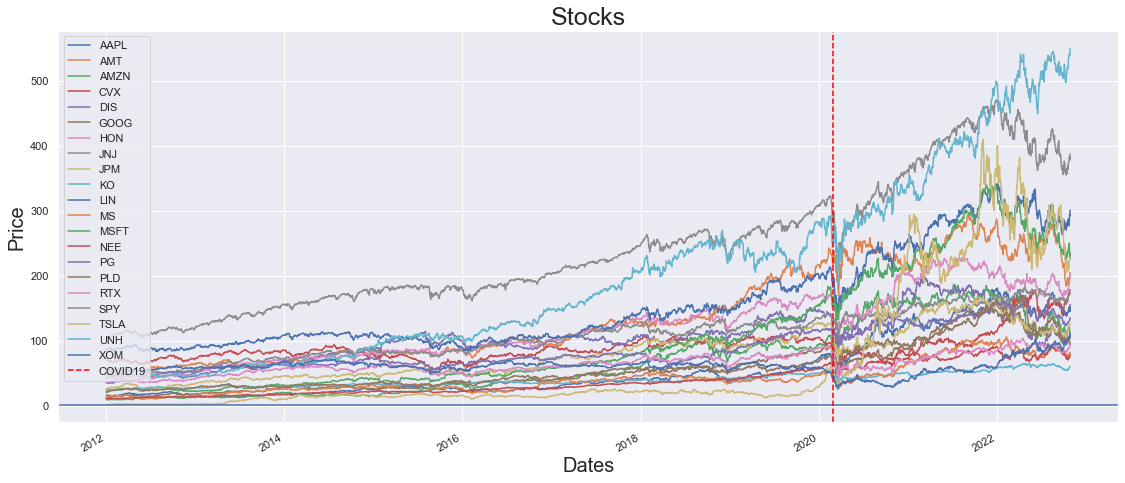

In [57]:
plot_data(stocks, 'Stocks', 'Dates', 'Price')

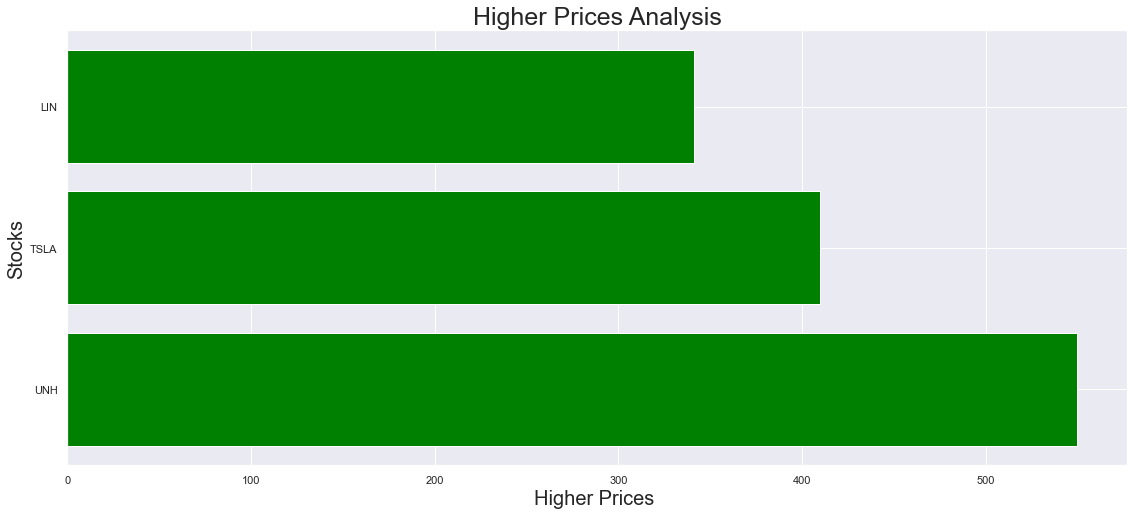

In [58]:
# higher prices
series_analysis(stocks.drop('SPY', axis=1).describe().loc['max'].sort_values(ascending=False)[:3], 'Higher Prices')

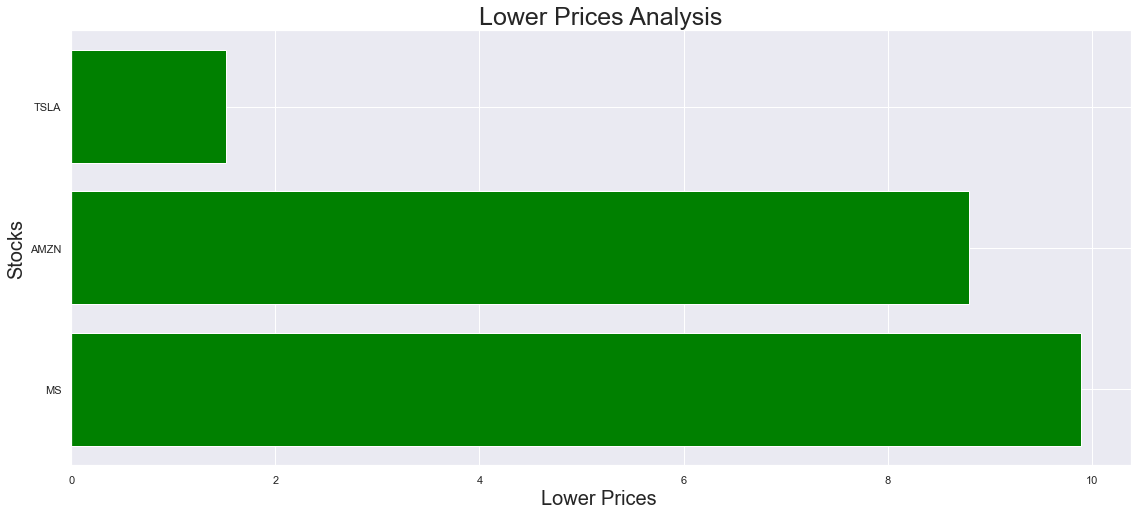

In [59]:
# lower prices
series_analysis(stocks.drop('SPY', axis=1).describe().loc['min'].sort_values(ascending=True)[:3], 'Lower Prices')

#### By analysing the plot above is possible to infer that the main tendency for all three stocks at the period was gorwth with some corrections movements. Those corrections probably are associated to changes in short term fundamentals for each or even a change in economy fundamentals during some short periods keeping the main tendency following the long term fundamentals.

In [60]:
# Evaluating if there is null values in the data
stocks.isnull().sum()

AAPL    0
AMT     0
AMZN    0
CVX     0
DIS     0
GOOG    0
HON     0
JNJ     0
JPM     0
KO      0
LIN     0
MS      0
MSFT    0
NEE     0
PG      0
PLD     0
RTX     0
SPY     0
TSLA    0
UNH     0
XOM     0
dtype: int64

# Fill Nan

In [61]:
# Dealing with missing data.
stocks.fillna(method='ffill', inplace=True)
stocks.fillna(method='bfill', inplace=True) # growth companies in general are newer compared to value companies and will need this method 

In [62]:
# Evaluating if there is null values in the data
stocks.isnull().sum()

AAPL    0
AMT     0
AMZN    0
CVX     0
DIS     0
GOOG    0
HON     0
JNJ     0
JPM     0
KO      0
LIN     0
MS      0
MSFT    0
NEE     0
PG      0
PLD     0
RTX     0
SPY     0
TSLA    0
UNH     0
XOM     0
dtype: int64

# Daily Return

In [63]:
d_return = daily_return(stocks, 1) 
d_return.head()

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2012-01-04,0.005374,0.014453,-0.008490,-0.001721,0.014096,0.004313,-0.000900,-0.006071,0.006335,-0.006273,...,-0.008707,0.023534,-0.002545,-0.000449,-0.025308,0.005223,0.001569,-0.013177,0.014566,0.000233
2012-01-05,0.011102,0.011566,0.000563,-0.009802,0.016731,-0.013871,0.001081,-0.001222,0.020887,-0.004734,...,0.021330,0.010219,0.012755,-0.004192,0.025965,-0.009594,0.002663,-0.021292,0.006700,-0.003022
2012-01-06,0.010454,-0.001657,0.028152,-0.007241,0.010380,-0.013642,-0.007376,-0.008716,-0.008969,-0.006343,...,-0.023342,0.015535,-0.010579,-0.002405,-0.015390,-0.005785,-0.002578,-0.007743,0.003613,-0.007463
2012-01-09,-0.001586,0.002821,-0.022178,0.010895,-0.004009,-0.042399,0.008336,0.001542,-0.001697,0.000000,...,0.018868,-0.013163,0.001188,0.004219,-0.009031,0.002706,0.002428,0.012635,-0.001137,0.004465


In [64]:
d_return.describe()

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
count,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,...,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000
mean,0.001091,0.000640,0.001103,0.000498,0.000540,0.000786,0.000678,0.000528,0.000728,0.000388,...,0.000886,0.001017,0.000816,0.000442,0.000734,0.000483,0.000541,0.002395,0.001055,0.000388
std,0.018216,0.014759,0.020292,0.017682,0.015924,0.016679,0.014072,0.010808,0.017028,0.011181,...,0.020171,0.016595,0.013499,0.011310,0.015535,0.016101,0.010643,0.035607,0.015751,0.016324
min,-0.128647,-0.151638,-0.140494,-0.221248,-0.129846,-0.111008,-0.120869,-0.100379,-0.149649,-0.096725,...,-0.156000,-0.147390,-0.134171,-0.087373,-0.172706,-0.144765,-0.109424,-0.210628,-0.172769,-0.122248
25%,-0.007393,-0.006592,-0.008528,-0.007285,-0.006635,-0.006603,-0.005624,-0.004289,-0.007387,-0.004521,...,-0.009390,-0.006569,-0.005384,-0.004716,-0.006851,-0.006164,-0.003523,-0.014726,-0.006750,-0.006944
50%,0.000855,0.000905,0.000979,0.000553,0.000448,0.000698,0.000701,0.000444,0.000431,0.000489,...,0.000836,0.000683,0.001202,0.000484,0.001150,0.000528,0.000630,0.001411,0.001038,0.000116
75%,0.010512,0.008112,0.011175,0.008150,0.007779,0.008858,0.007288,0.005900,0.008866,0.005875,...,0.011554,0.009178,0.007230,0.005875,0.008875,0.007349,0.005453,0.019081,0.008421,0.007665
max,0.119808,0.122220,0.157457,0.227407,0.144123,0.160524,0.150683,0.079977,0.180125,0.064796,...,0.197701,0.142169,0.136904,0.120090,0.118103,0.157572,0.090603,0.243951,0.127989,0.126868


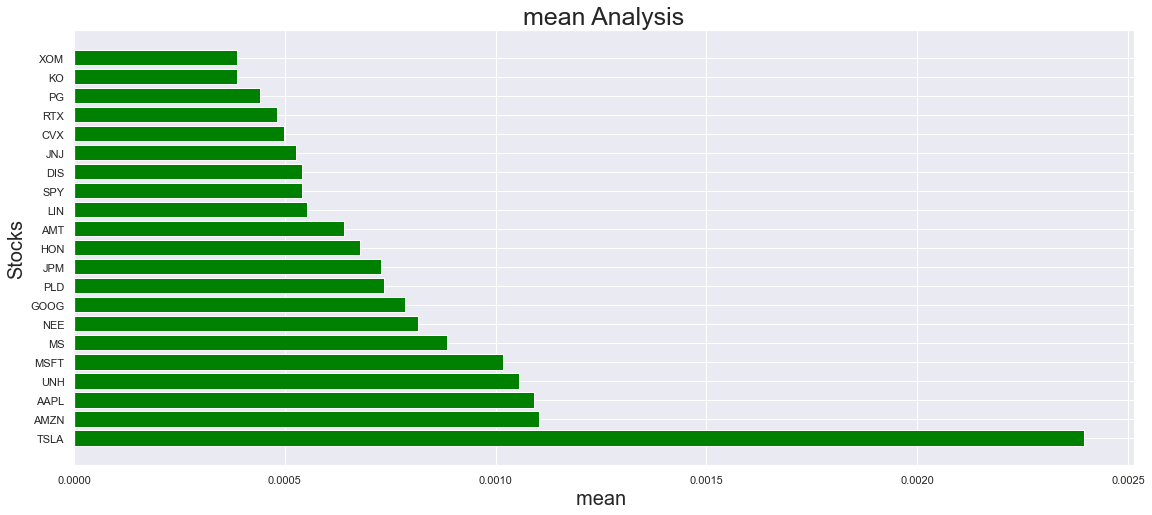

In [65]:
mean = d_return.describe().loc['mean']
series_analysis(mean, 'mean')

## Daily return behaviour

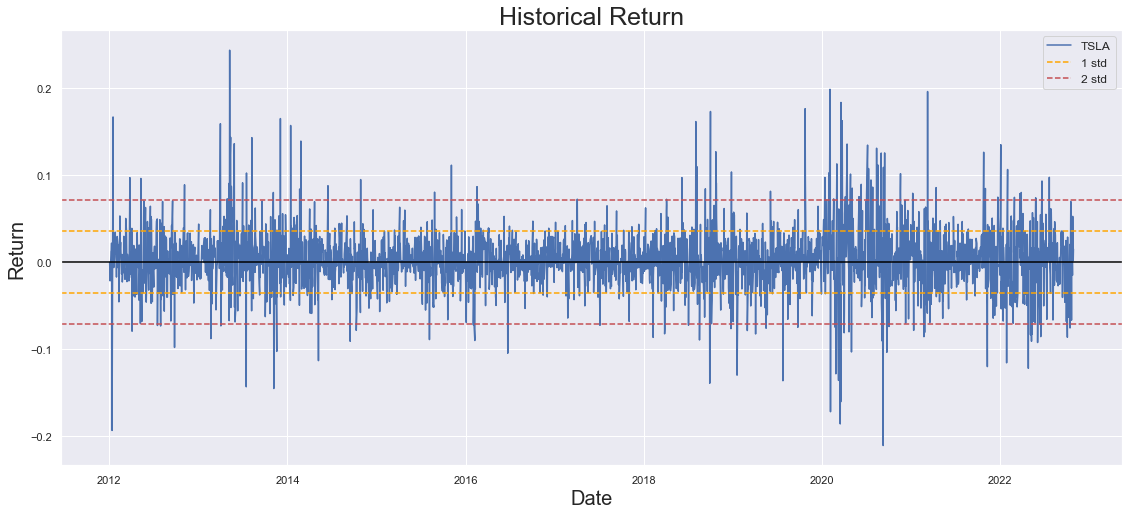

In [66]:
plot_line(d_return['TSLA'])

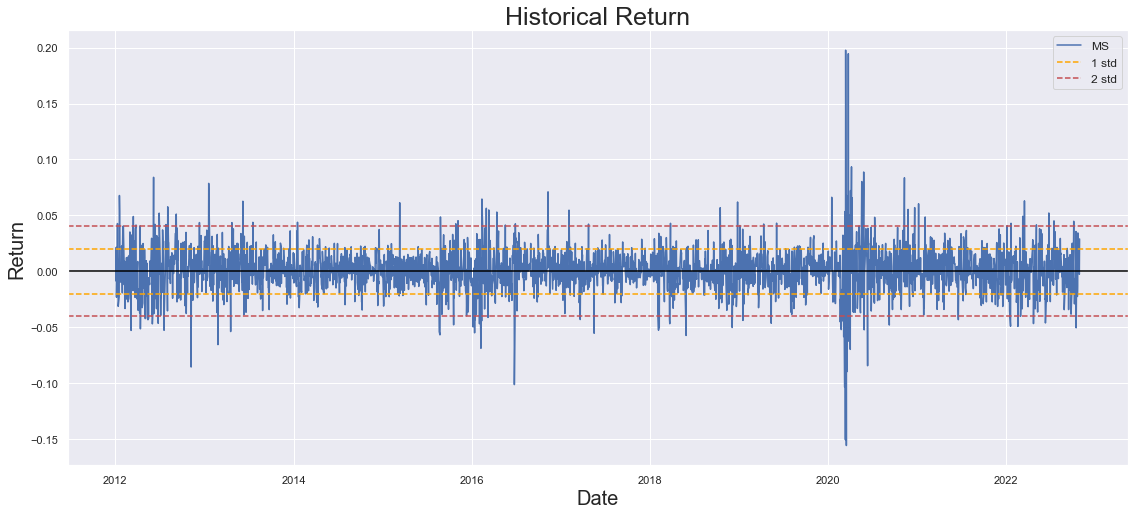

In [67]:
plot_line(d_return['MS'])

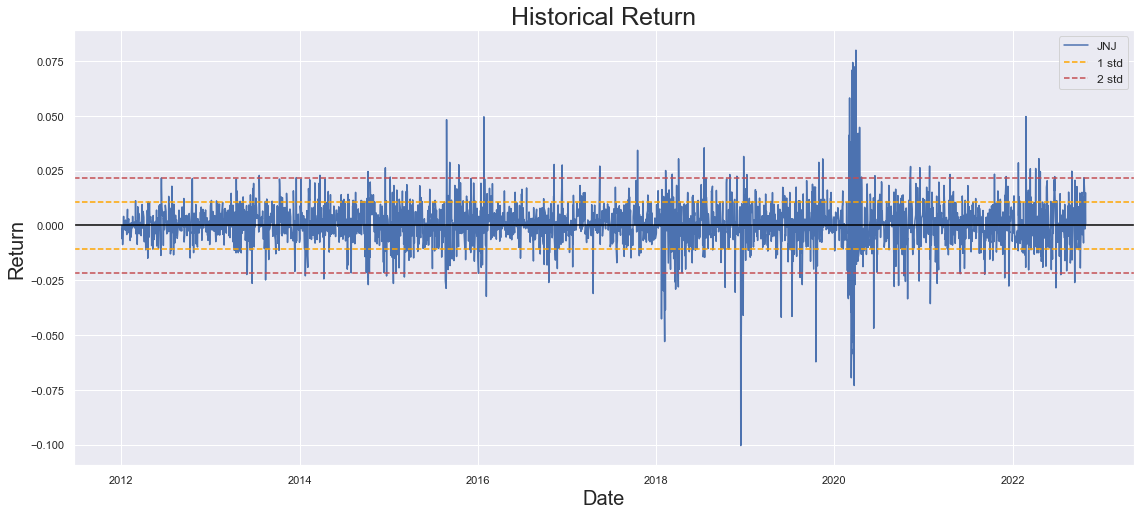

In [68]:
plot_line(d_return['JNJ'])

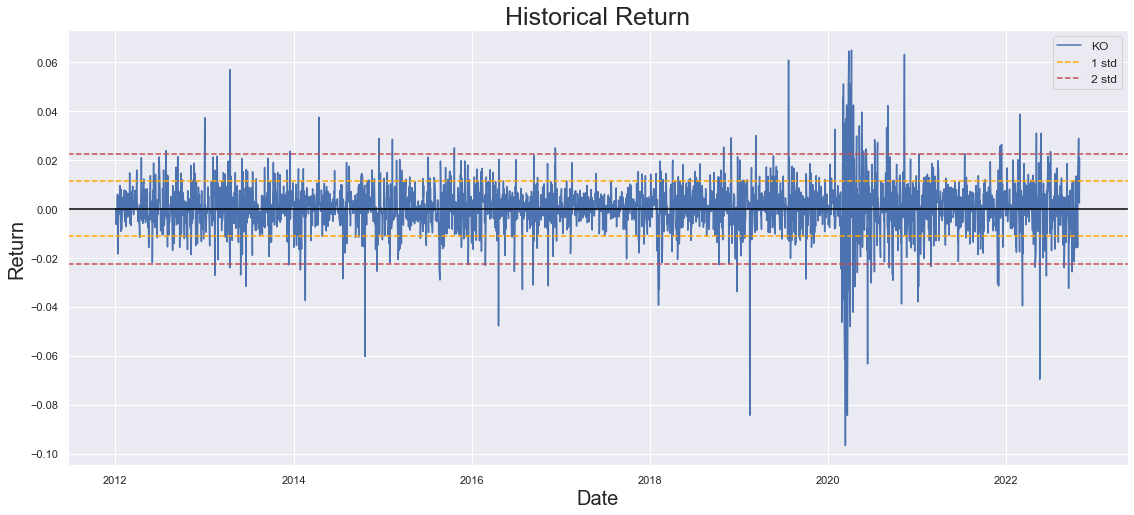

In [69]:
plot_line(d_return['KO'])

## Daily return behaviour - Histogram

The Kurtosis is: 5.587540539448287


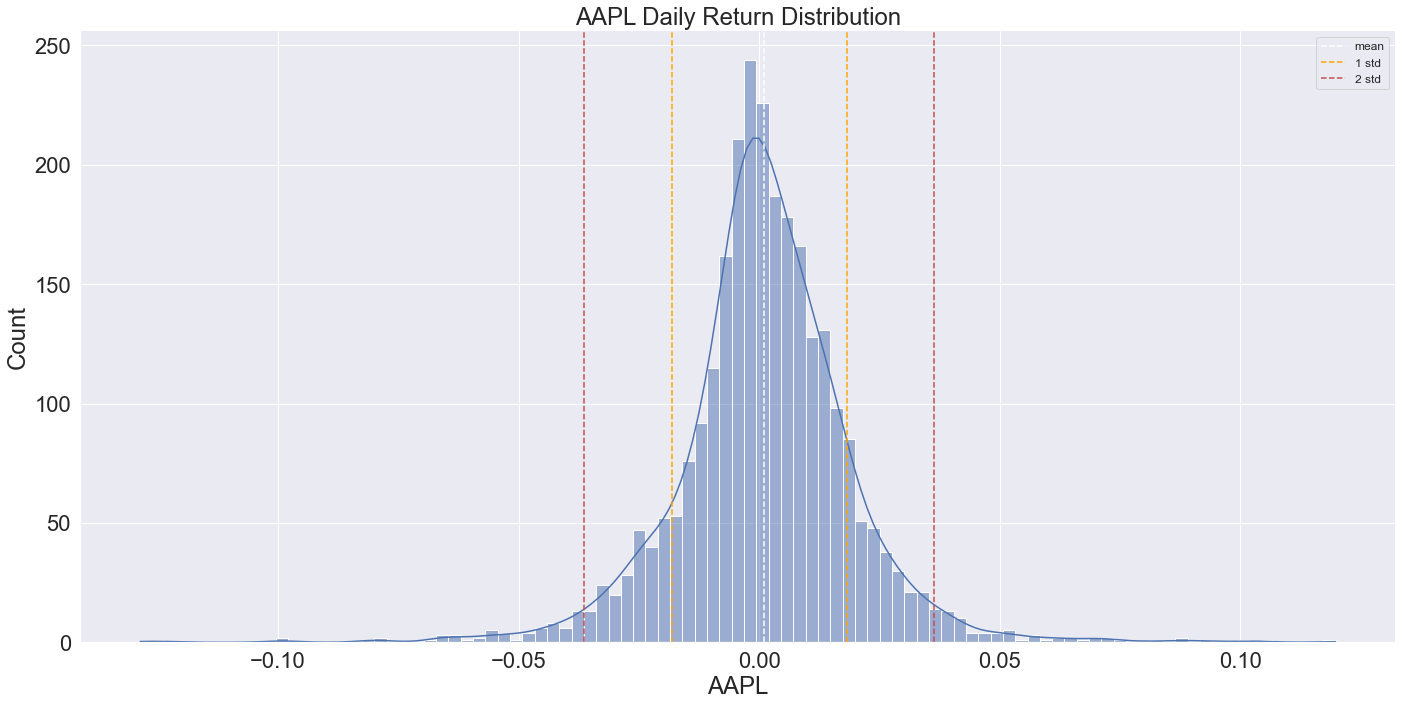

In [70]:
hist_seaborn(d_return['AAPL'])

# Metrics - Return: CAGR (Compounded Annual Growth Rate)

#### CAGR provides easy way of comparison between different trading strategies. Does not reflect investiment risk

In [71]:
CAGR_list = []
for ticker in stocks:
    temp = (ticker, CAGR(stocks[ticker]))
    CAGR_list.append(temp)  
CAGR_list.sort(key=lambda x: x[1], reverse=True)
for i in CAGR_list:
    print(f'CAGR {i[0]} {i[1]}% a.a')

CAGR TSLA 55.94% a.a
CAGR UNH 26.43% a.a
CAGR AAPL 26.23% a.a
CAGR AMZN 25.39% a.a
CAGR MSFT 24.78% a.a
CAGR NEE 20.03% a.a
CAGR MS 18.77% a.a
CAGR GOOG 17.7% a.a
CAGR PLD 16.69% a.a
CAGR JPM 15.83% a.a
CAGR HON 15.72% a.a
CAGR AMT 14.31% a.a
CAGR SPY 12.97% a.a
CAGR JNJ 12.55% a.a
CAGR LIN 12.23% a.a
CAGR DIS 10.99% a.a
CAGR PG 10.01% a.a
CAGR RTX 9.3% a.a
CAGR CVX 8.96% a.a
CAGR KO 8.53% a.a
CAGR XOM 6.62% a.a


# Metrics - Return: Total Return

In [72]:
# Total Return
total_return = (stocks.iloc[-1,:] / stocks.iloc[0,:] -1) * 100 
total_return.sort_values(ascending=False, inplace=True)
total_return

TSLA    12107.265322
UNH      1163.020674
AAPL     1141.941455
AMZN     1055.225430
MSFT      995.683550
NEE       619.988816
MS        542.681903
GOOG      482.750536
PLD       430.930385
JPM       389.872557
HON       384.776356
AMT       324.513645
SPY       273.799252
JNJ       259.056754
LIN       248.367585
DIS       208.886527
PG        180.429778
RTX       161.606757
CVX       152.949128
KO        142.277930
XOM        99.969589
dtype: float64

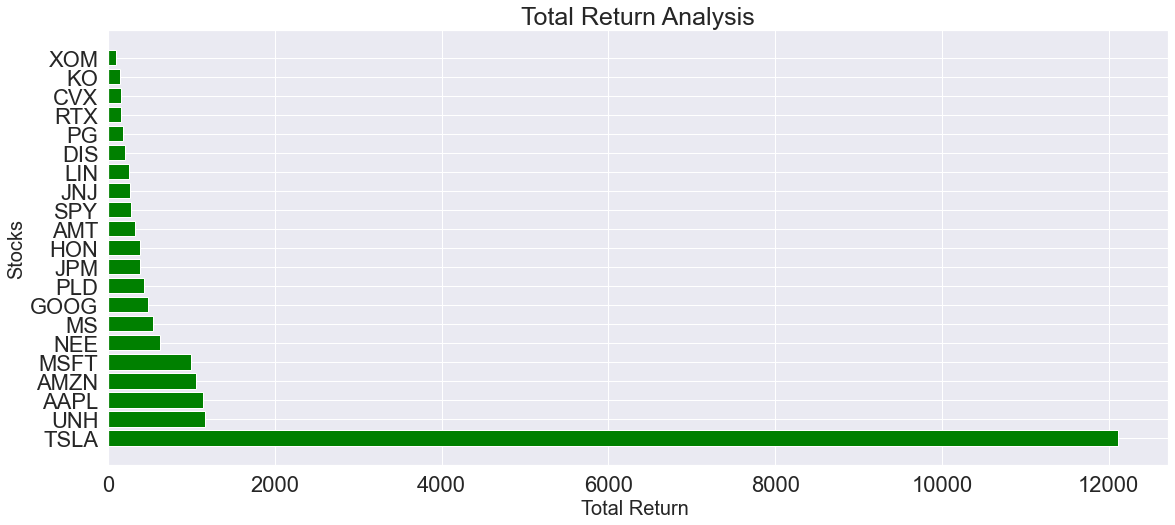

The TSLA UNH AMZN had the highest growth in the period


In [73]:
# PLot Total Return
series_analysis(total_return, 'Total Return')
print(f'The {total_return.index[0]} {total_return.index[1]} {total_return.index[3]} had the highest growth in the period')

#### Tesla had the higher growth compared to the other stocks that seem to be more reasonable in terms of total return dispersion

#### Four of the five higher total return are associated to the Sectors: Technology: Consumer Electronics, Technology: Software Infrastructure, Consumer Cyclical: Internet Retail, Consumer Cyclical: Auto Manufacturers. This shows the strength and relevance of these sectors to the US Economy.

### Top 3. Technology: Consumer, Electronics Consumer Cyclical: Auto Manufacturers and Healthcare: Healthcare Plans

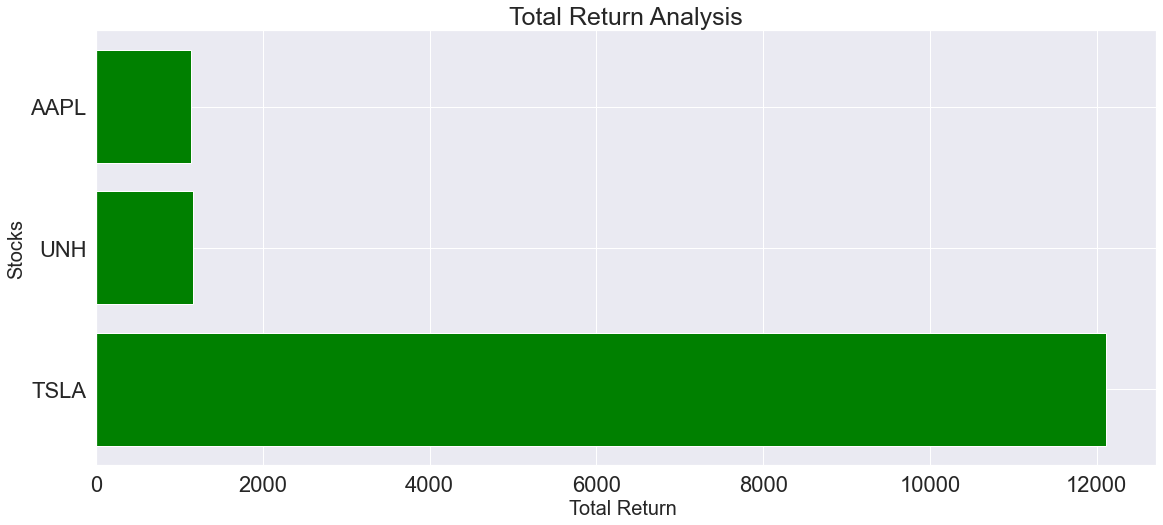

In [74]:
series_analysis(total_return[:3], 'Total Return')

### Last 3. Two from Energy: Oil & Gas Sector and one from Consumer Defensive: Beverages - Non Alcoholic

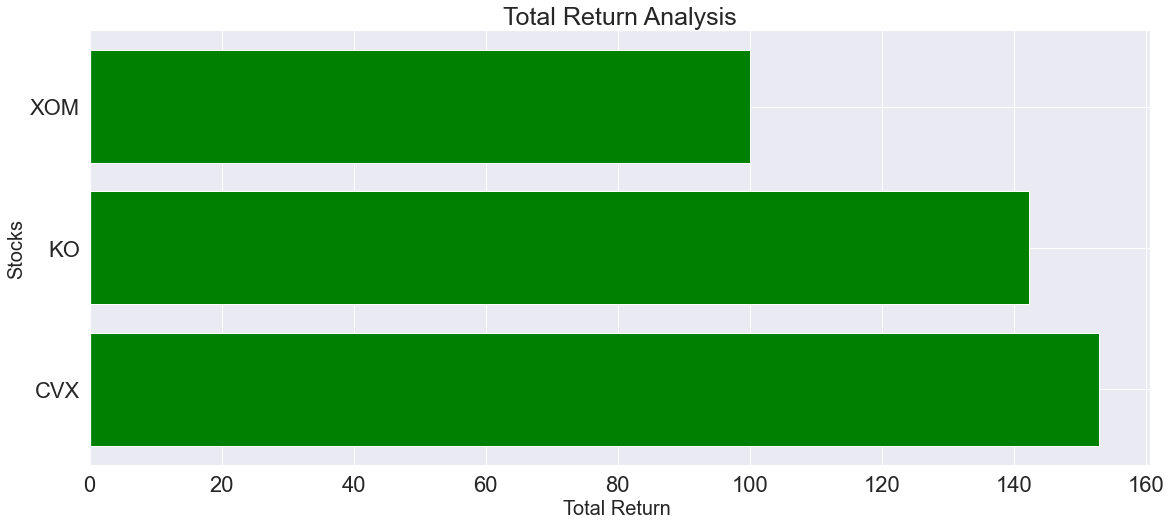

In [75]:
series_analysis(total_return[-3:], 'Total Return')

#### To get a better understand of the stocks growth lets normalize the data, by taking all values and divide for the first row. Doing that all stocks will start from the same value and will reflect with more effectiveness the relative growth

# Cumulative Return

In [76]:
# Cumulative return between start date and end date
norm_df = norm(stocks, '2002-01-02','2022-01-02')
norm_df.head()

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2012-01-04,1.005374,1.014453,0.991510,0.998279,1.014096,1.004313,0.999100,0.993929,1.006335,0.993727,...,0.991293,1.023534,0.997455,0.999551,0.974692,1.005223,1.001569,0.986823,1.014566,1.000233
2012-01-05,1.016536,1.026186,0.992068,0.988494,1.031062,0.990382,1.000180,0.992714,1.027354,0.989022,...,1.012438,1.033993,1.010178,0.995361,1.000000,0.995579,1.004235,0.965812,1.021364,0.997210
2012-01-06,1.027163,1.024486,1.019997,0.981336,1.041765,0.976871,0.992803,0.984062,1.018140,0.982749,...,0.988806,1.050056,0.999491,0.992967,0.984610,0.989820,1.001647,0.958333,1.025054,0.989768
2012-01-09,1.025534,1.027376,0.997375,0.992027,1.037588,0.935453,1.001079,0.985580,1.016412,0.982749,...,1.007463,1.036234,1.000679,0.997157,0.975718,0.992499,1.004079,0.970442,1.023888,0.994187


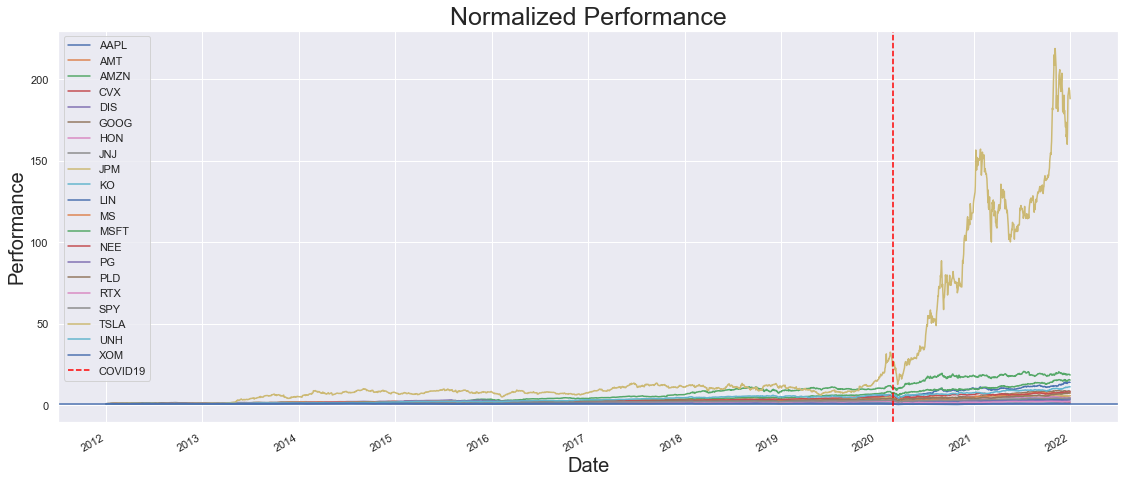

In [77]:
# Normalized cumulative return
plot_data(norm_df, 'Normalized Performance', 'Date', 'Performance')

# Cumulative Return by Sectors

#### Tech and Communication Companies

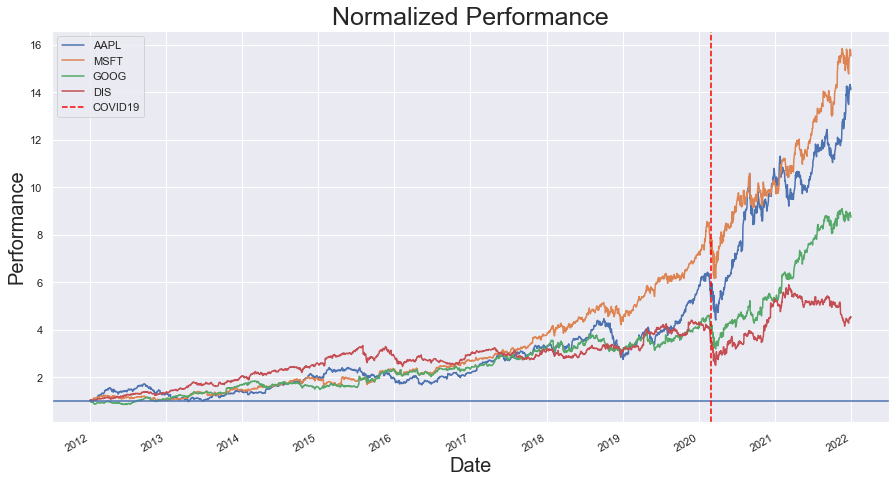

In [27]:
plot_data(norm_df[['AAPL', 'MSFT', 'GOOG','DIS']],'Normalized Performance', 'Date', 'Performance')

#### Consumer Cyclical and Defensive Companies

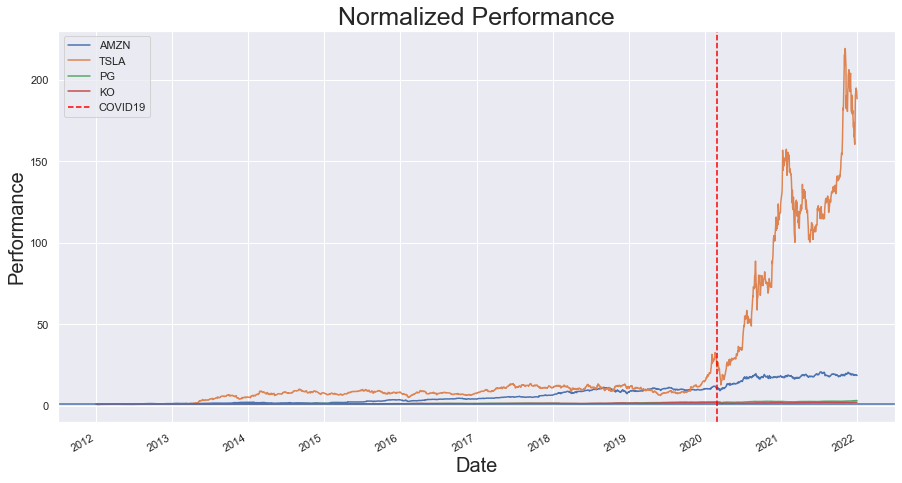

In [28]:
plot_data(norm_df[['AMZN','TSLA','PG','KO']],'Normalized Performance', 'Date', 'Performance')

#### Financial and Real State Companies

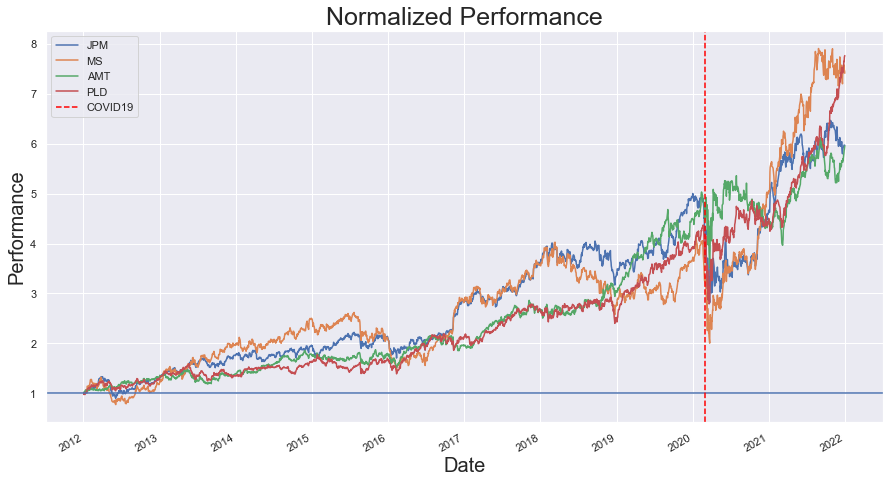

In [29]:
plot_data(norm_df[['JPM', 'MS', 'AMT','PLD']],'Normalized Performance', 'Date', 'Performance')

#### Industrials and Basic Materials Companies

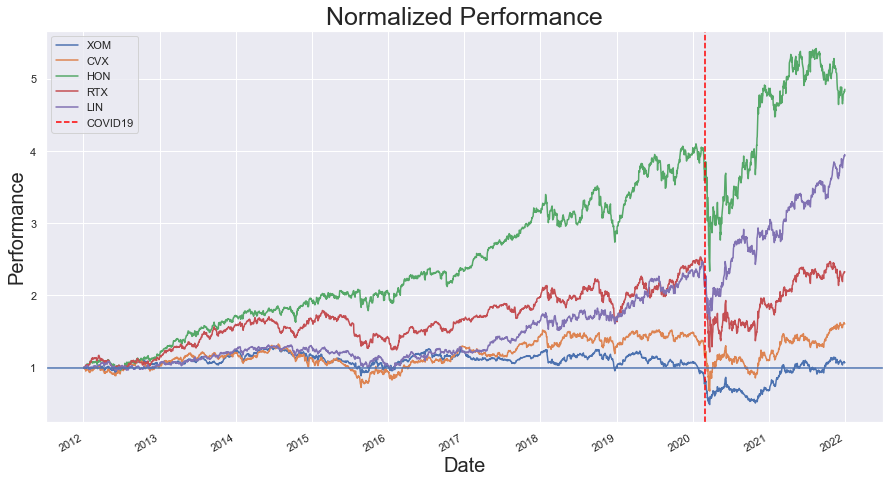

In [30]:
plot_data(norm_df[['XOM','CVX','HON','RTX', 'LIN']],'Normalized Performance', 'Date', 'Performance')

####  Energy

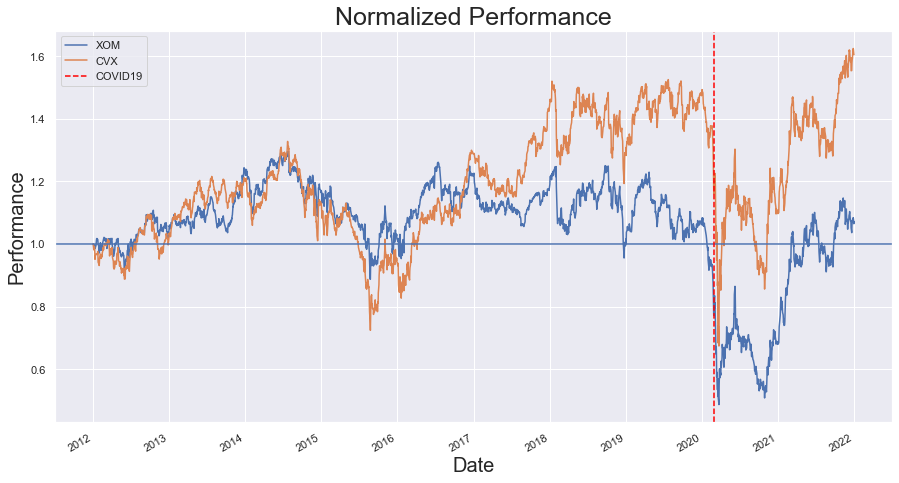

In [31]:
plot_data(norm_df[['XOM','CVX']],'Normalized Performance', 'Date', 'Performance')

#### Healthcare and Utilities Companies

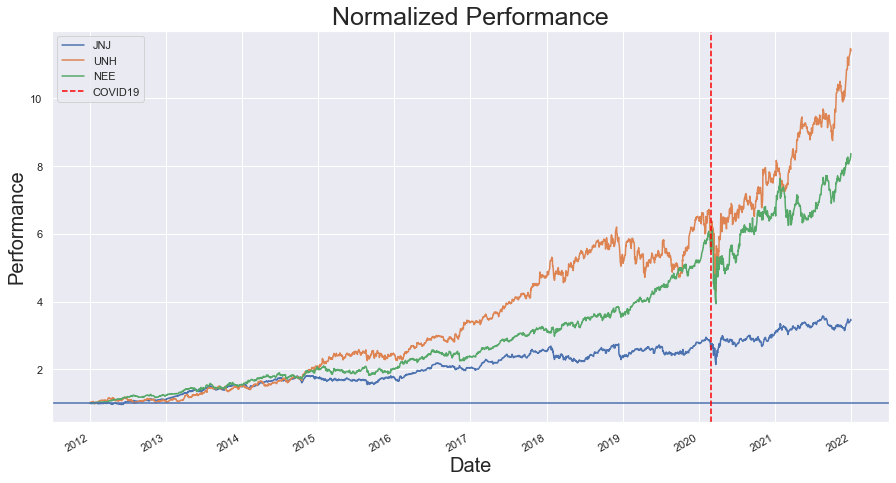

In [32]:
plot_data(norm_df[['JNJ','UNH','NEE']],'Normalized Performance', 'Date', 'Performance')

# Metrics - Risk (Volatility)

#### Volatility of a strategy is represented by the standard deviation of the returns. This represent the variability of returns from mean return. To annualize daiy volatility is necessary multiply by square root of 252. This metric is widely used as a measure of risk, however, this approach assumes normal distribution of returns. This approach doesn't capture the tail risk.

In [33]:
# Annual Volatility
Vol_list = []
for ticker in d_return:
    temp = (ticker, volatility(stocks[ticker]))
    Vol_list.append(temp) 
    
Vol_list.sort(key=lambda x: x[1], reverse=True)
for i in Vol_list:
    print(f'Volatility {i[0]} {i[1]}% a.a')

Volatility TSLA 56.54% a.a
Volatility AMZN 32.22% a.a
Volatility MS 32.03% a.a
Volatility AAPL 28.92% a.a
Volatility CVX 28.07% a.a
Volatility JPM 27.04% a.a
Volatility GOOG 26.48% a.a
Volatility MSFT 26.35% a.a
Volatility XOM 25.92% a.a
Volatility RTX 25.56% a.a
Volatility DIS 25.28% a.a
Volatility UNH 25.01% a.a
Volatility PLD 24.67% a.a
Volatility AMT 23.43% a.a
Volatility HON 22.34% a.a
Volatility LIN 21.89% a.a
Volatility NEE 21.43% a.a
Volatility PG 17.96% a.a
Volatility KO 17.75% a.a
Volatility JNJ 17.16% a.a
Volatility SPY 16.9% a.a


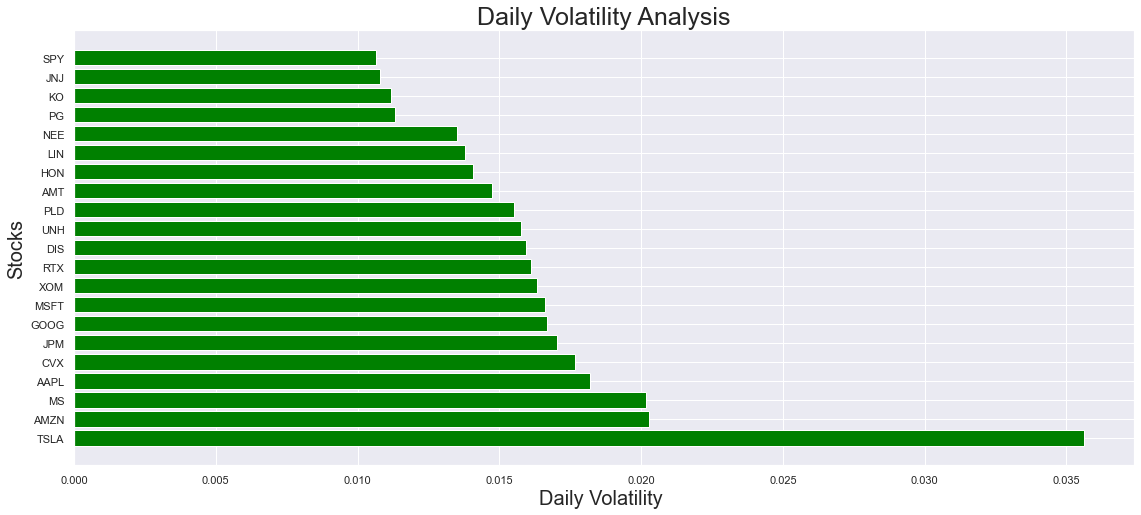

In [34]:
# Plot of Daily Return Volatility
std = d_return.describe().loc['std']
series_analysis(std, 'Daily Volatility')

In [35]:
def sharpe_ratio(df, risk_free):
    IS = (CAGR(df) - risk_free) / volatility(df)
    return IS

# Metrics Risk Adjusted Return: Sharpe

#### Measures the performance of an investment compared to a risk-free asset, after adjusting for its risk. Shows how well were the stocks performance were given the risk involved. 

#### Evaluate return isolated gives just one piece of the jigsaw as well evaluate the volatility isolated. However using metrics that reflects the risk adjusted return shows us the efficiency.

In [36]:
# Sharpe Ratio
sharpe_list = []
for ticker in stocks:
    temp = (ticker, sharpe_ratio(stocks[ticker], .3)) 
    sharpe_list.append(temp) 
    
sharpe_list.sort(key=lambda x: x[1], reverse=True)
for i in sharpe_list:
    print(f'Sharpe {i[0]} {round(i[1],2)}% a.a')

Sharpe UNH 1.04% a.a
Sharpe TSLA 0.98% a.a
Sharpe MSFT 0.93% a.a
Sharpe NEE 0.92% a.a
Sharpe AAPL 0.9% a.a
Sharpe AMZN 0.78% a.a
Sharpe SPY 0.75% a.a
Sharpe JNJ 0.71% a.a
Sharpe HON 0.69% a.a
Sharpe PLD 0.66% a.a
Sharpe GOOG 0.66% a.a
Sharpe AMT 0.6% a.a
Sharpe MS 0.58% a.a
Sharpe JPM 0.57% a.a
Sharpe LIN 0.54% a.a
Sharpe PG 0.54% a.a
Sharpe KO 0.46% a.a
Sharpe DIS 0.42% a.a
Sharpe RTX 0.35% a.a
Sharpe CVX 0.31% a.a
Sharpe XOM 0.24% a.a


# Scatter Plots

Beta Coeficient between SPY and JPM is 1.184860413848441
Alpha Coeficient between SPY and JPM is 8.711918761961066e-05


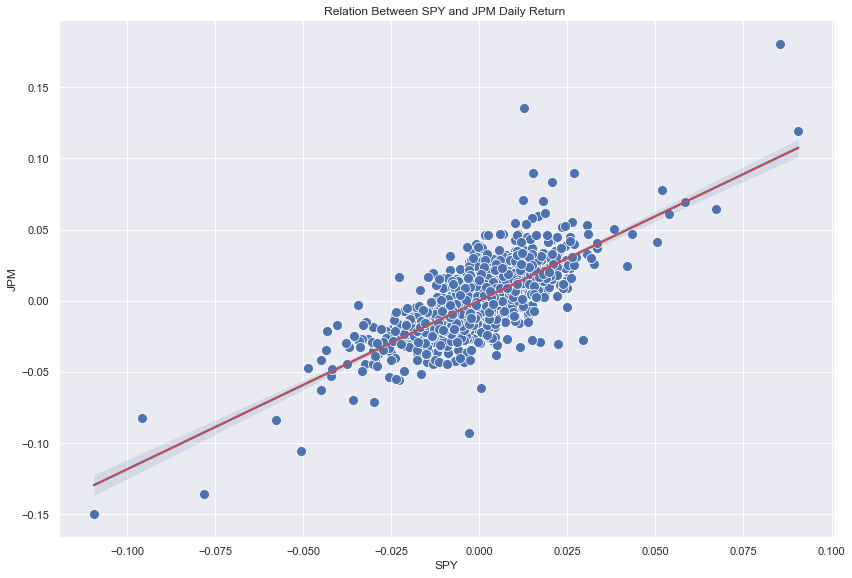

In [37]:
scatter_searborn(d_return, 'SPY', 'JPM')

Beta Coeficient between SPY and JNJ is 0.6122098109007214
Alpha Coeficient between SPY and JNJ is 0.0001965902052089118


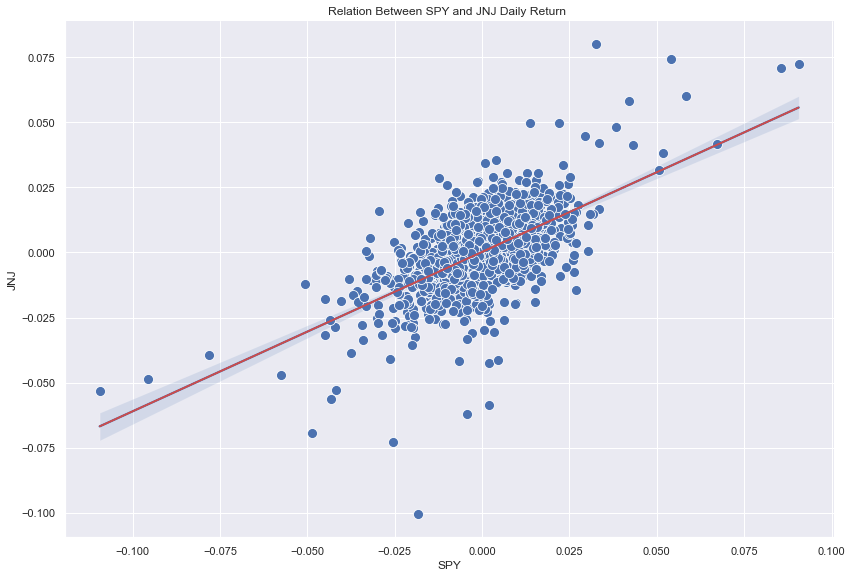

In [38]:
scatter_searborn(d_return, 'SPY', 'JNJ')

# Let's Classify the stocks into Riskier and Safier


#### This process can be done by analyzing the Beta coefficient that measures the relationship between the market and the stock. This is the slope of the curve obtained from the linear regression and represents the change in the stock every 1 unit change in the market reference (SPY). Values equal to one represents that the stock in general folows the market movements. Values higher than one represents that the stocks change more than the market reference and consequently is considered a riskier stock. Values lower than one represents that the stock change less than the market reference and is considered safier 

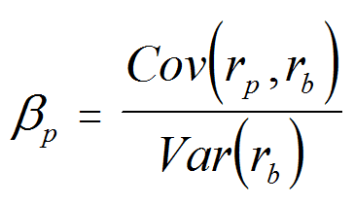

In [39]:
stocks_params = []
for stock in d_return:
    # get beta and alpha
    beta, alpha = np.polyfit(d_return['SPY'], d_return[stock], 1)
    temp = (stock, round(beta, 2), round(alpha, 4))
    stocks_params.append(temp)

stocks_params.sort(key=lambda x: x[1], reverse=True)
for i in stocks_params:
    print(f'{i[0]} | Beta {i[1]} | Alpha {i[2]}')

TSLA | Beta 1.44 | Alpha 0.0016
MS | Beta 1.42 | Alpha 0.0001
MSFT | Beta 1.19 | Alpha 0.0004
AAPL | Beta 1.18 | Alpha 0.0005
JPM | Beta 1.18 | Alpha 0.0001
AMZN | Beta 1.12 | Alpha 0.0005
GOOG | Beta 1.11 | Alpha 0.0002
CVX | Beta 1.06 | Alpha -0.0001
RTX | Beta 1.05 | Alpha -0.0001
HON | Beta 1.03 | Alpha 0.0001
DIS | Beta 1.01 | Alpha -0.0
SPY | Beta 1.0 | Alpha -0.0
PLD | Beta 0.98 | Alpha 0.0002
LIN | Beta 0.95 | Alpha 0.0
UNH | Beta 0.93 | Alpha 0.0006
XOM | Beta 0.93 | Alpha -0.0001
AMT | Beta 0.8 | Alpha 0.0002
NEE | Beta 0.68 | Alpha 0.0004
KO | Beta 0.64 | Alpha 0.0
JNJ | Beta 0.61 | Alpha 0.0002
PG | Beta 0.6 | Alpha 0.0001


#### In moments when the economy goes up the riskier stocks will outperform the market and certainly the safer stocks, but on the other hand in a recession period the safer stocks will suffer less. This kind of statistics is fundamental to create a portfolio to capture the best perform depending of what is expected for the next months and years

# Correlation

#### Measure of dependence between two variables.This is the key to have optimization of risk and reward on selecting stocks for a portfolio. The Correlation can vary depending on the time series used to calculate

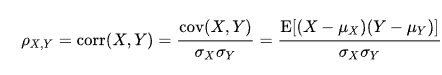

# Portfolio Stantard Deviation

#### In general as the correlation reduces, the risk of the portfolio reduces due to the diversification benefits. This benefits can be achieved by selecting stocks with negative correlation

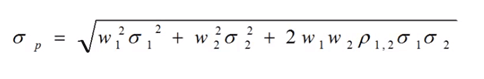

<AxesSubplot:>

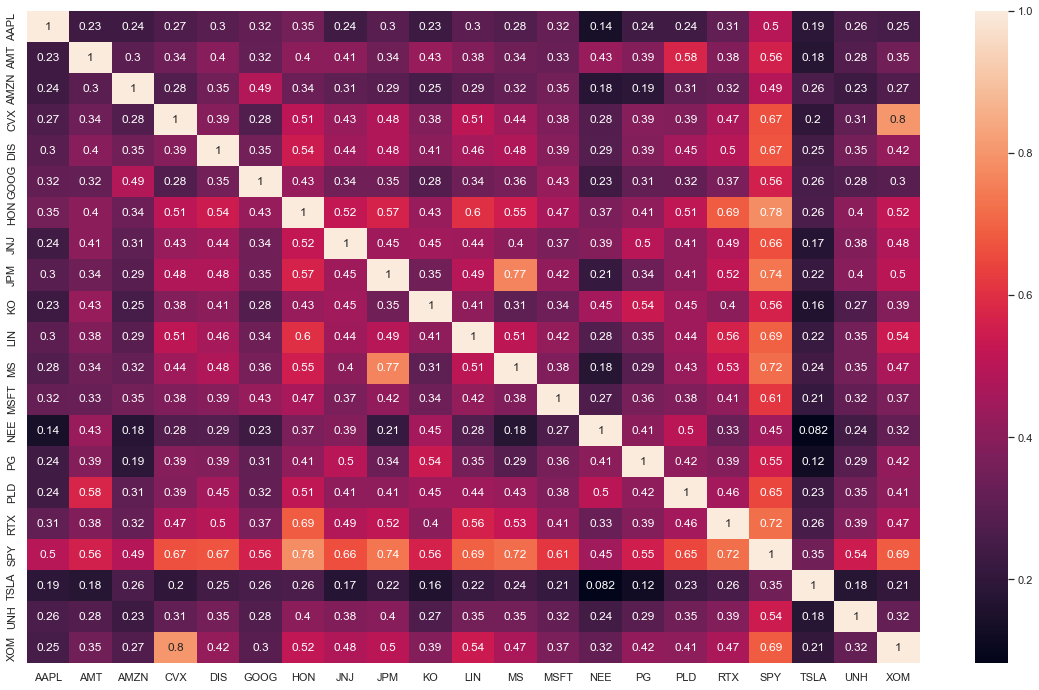

In [40]:
d_return_corr = d_return.loc['2012-01-01':'2017-01-01',:].corr(method='pearson')
sns.set(rc = {'figure.figsize':(20,12)})
sns.heatmap(d_return_corr, annot=True)

<AxesSubplot:>

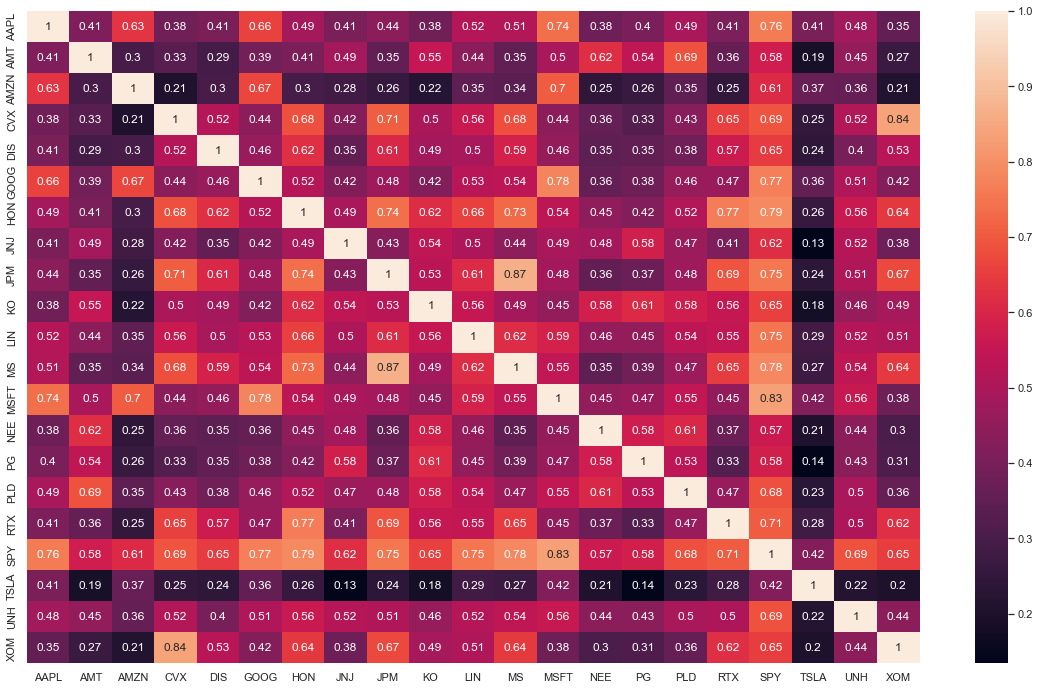

In [41]:
d_return_corr = d_return.loc['2017-01-01':'2022-01-01',:].corr(method='pearson')
sns.set(rc = {'figure.figsize':(20,12)})
sns.heatmap(d_return_corr, annot=True)

#### The different  color's positions show that the Correlation Matrix has changed as the sample changed. That evidence reveals that is always important evaluate the sectors and the stocks before selecting for a portfolio to get the benefit of diversification.

# Technical Analysis

#### Simple Moving Average are often used to determine trend direction. It is simply the average price over the specified period.

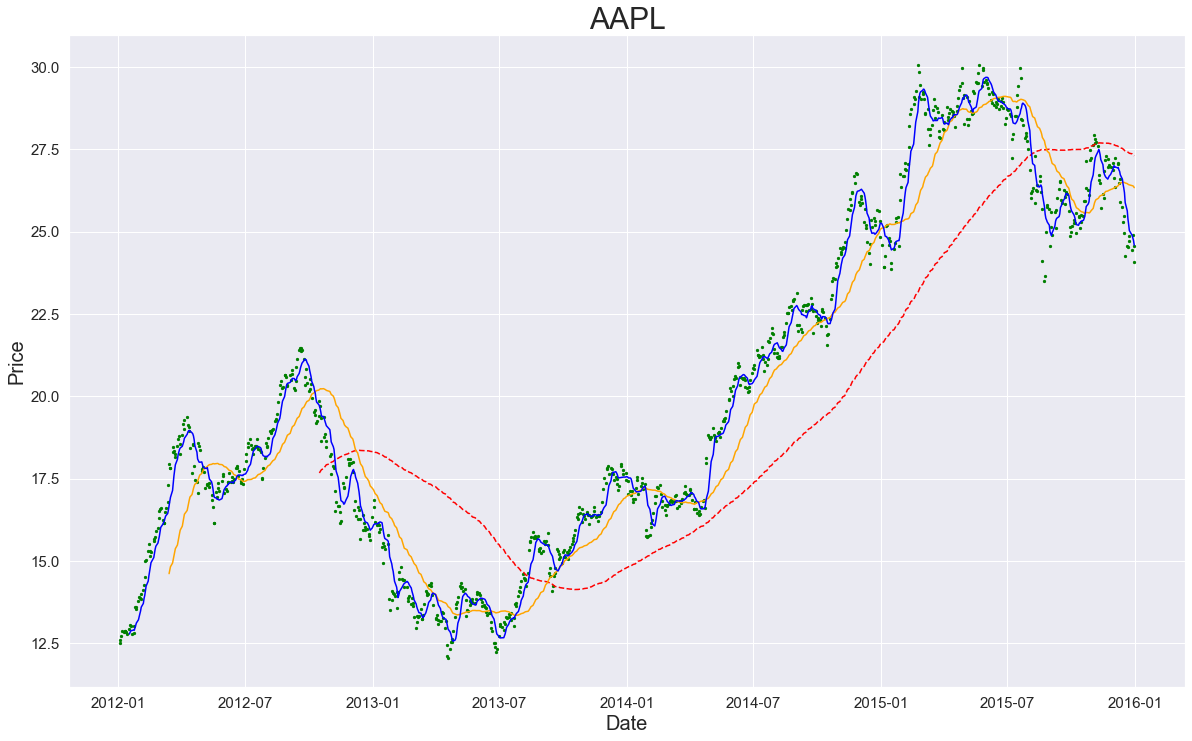

In [42]:
SMA_plot(stocks.AAPL.loc['2012-01-03':'2016-01-03'], 200,50,10)

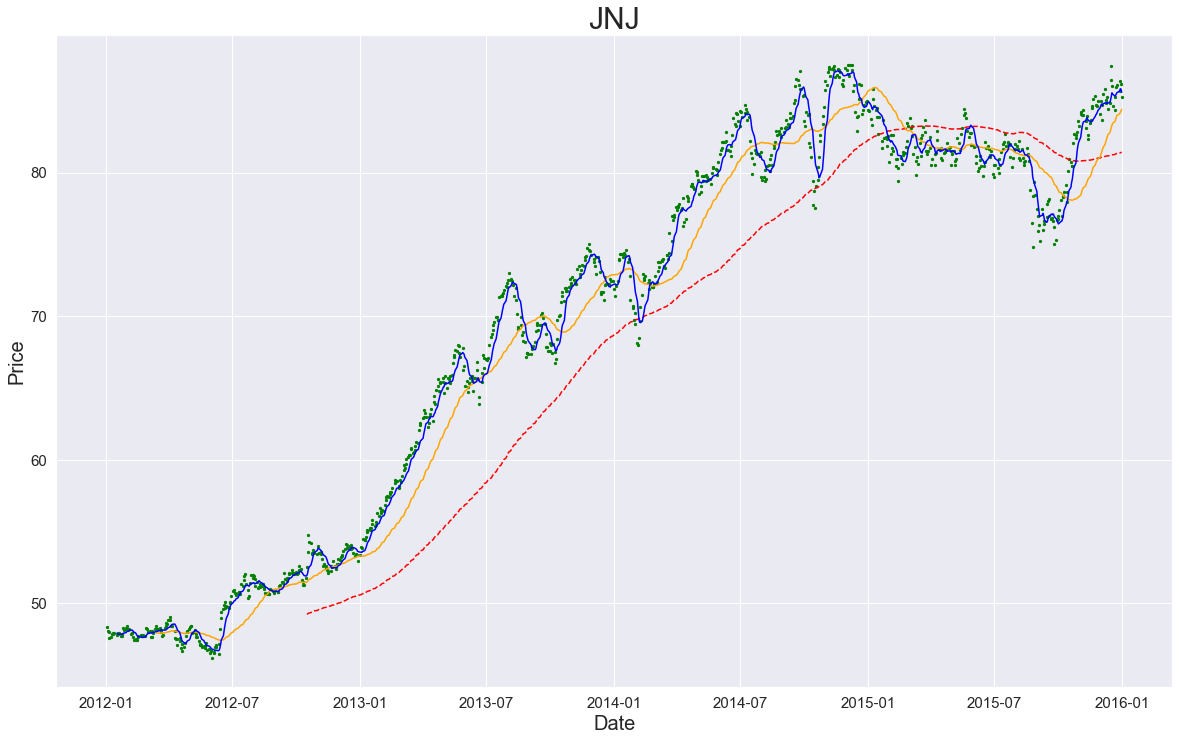

In [43]:
SMA_plot(stocks.JNJ.loc['2012-01-03':'2016-01-03'], 200,50,10)

#### Bollinger Bands indicator is made up of 3 lines  – a middle band and two outer ones. The middle band is simple moving average. The outer bands are numbers of standard deviations above and below the middle band.

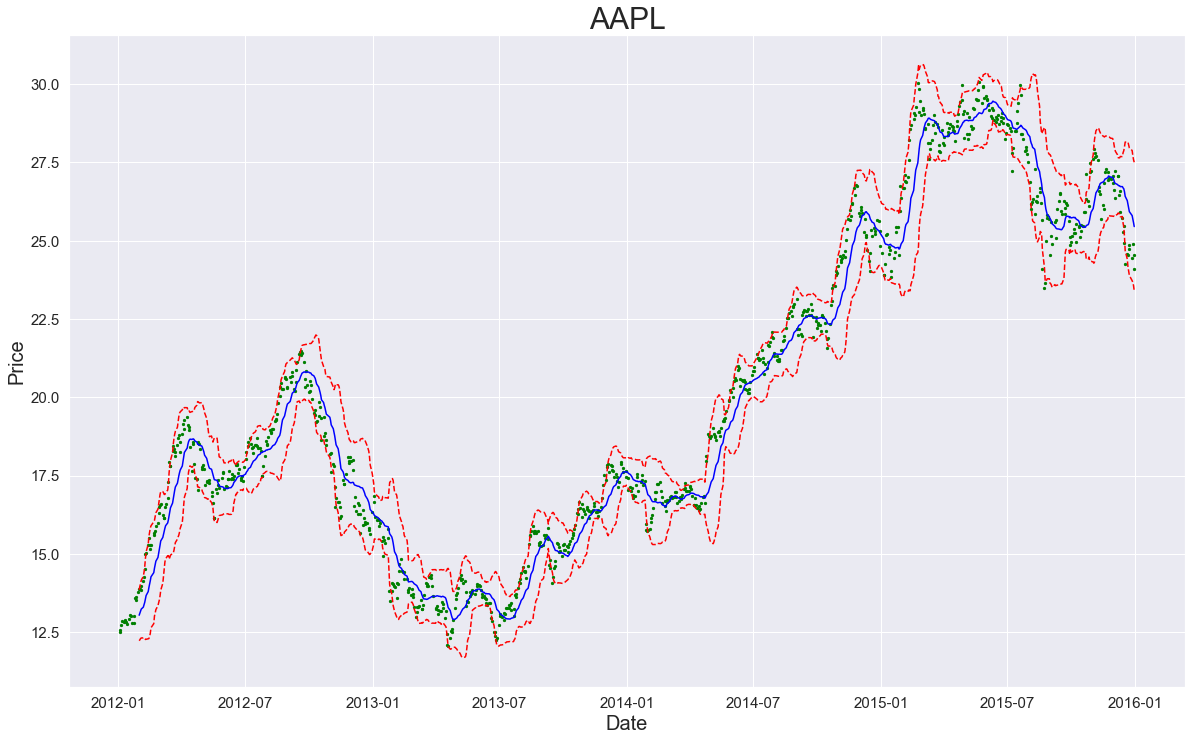

In [44]:
BB_plot(stocks.AAPL.loc['2012-01-03':'2016-01-03'], 20, 2)

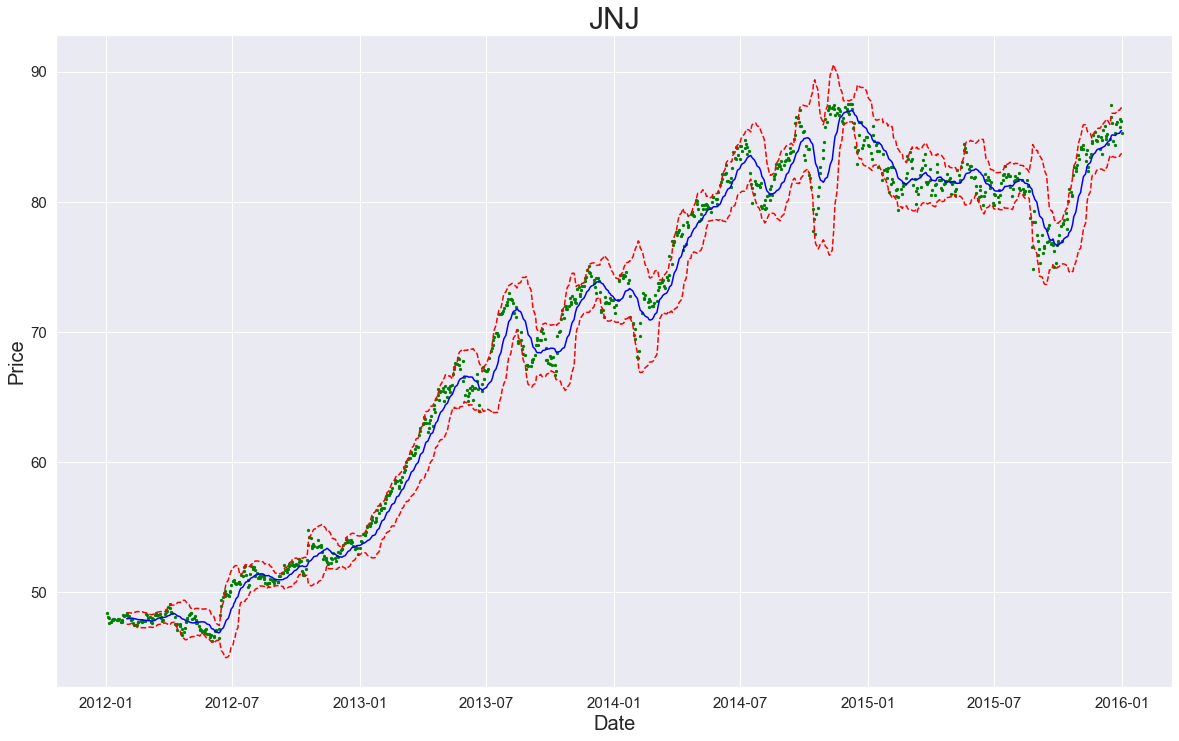

In [45]:
BB_plot(stocks.JNJ.loc['2012-01-03':'2016-01-03'], 20, 2)

# Machine Learn

# Linear Regression

In [46]:
data = get_data(['AAPL'], '2012-03-11', '2022-07-10')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-03-12,19.606428,19.714287,19.535713,19.714287,16.804817,407282400
2012-03-13,19.912144,20.292143,19.848213,20.289286,17.294949,690855200
2012-03-14,20.644644,21.240000,20.549999,21.056429,17.948877,1418844000
2012-03-15,21.414642,21.428928,20.662500,20.912857,17.826490,1159718000
2012-03-16,20.882856,21.042856,20.642857,20.913214,17.826799,825487600


In [47]:
# Other Features
data['RSI'] = ta.rsi(data['Adj Close'], lenghth=15)
data['EMAF'] = ta.ema(data['Adj Close'], lenght=20)
data['EMAM'] = ta.ema(data['Adj Close'], lenght=100)
data['EMAS'] = ta.ema(data['Adj Close'], lenght=150)
data['BBupper 2'] = bollinger_bands(data['Adj Close'], 2, 2)[1]
data['BBlower 2'] = bollinger_bands(data['Adj Close'], 2, 2)[2]
#defining Predict as the next Adj Close Price
data['Predict Next Day'] = data['Adj Close'].shift(-1)
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

In [48]:
data_set = data.iloc[:, 0:11]#.values
pd.set_option('display.max_columns', None)

data_set.head()

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,BBupper 2,BBlower 2,Predict Next Day
0,21.741785,21.805714,21.355000,18.252398,62.345138,18.307246,18.307246,18.307246,18.853214,17.965452,18.833263
1,21.493929,22.098928,21.442142,18.833263,71.070978,18.402885,18.402885,18.402885,19.364299,17.721362,19.158697
2,22.403570,22.578930,22.232500,19.158697,74.619573,18.540306,18.540306,18.540306,19.456213,18.535747,19.006180
3,22.298214,22.352142,22.035713,19.006180,70.269176,18.625010,18.625010,18.625010,19.298131,18.866746,19.291443
4,22.392143,22.666430,22.264286,19.291443,73.393622,18.746180,18.746180,18.746180,19.552234,18.745388,19.369068


In [49]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1)) #will rescale the values between 0 and 1
data_set_scaled = sc.fit_transform(data_set)

data_set_scaled

array([[0.04672353, 0.04466917, 0.04596718, ..., 0.03875666, 0.03716418,
        0.04007621],
       [0.04525496, 0.04640757, 0.04649415, ..., 0.04171363, 0.03569722,
        0.04200305],
       [0.05064466, 0.0492534 , 0.05127359, ..., 0.04224541, 0.0405916 ,
        0.04110002],
       ...,
       [0.73420066, 0.75496323, 0.7448696 , ..., 0.76007537, 0.74720417,
        0.77219972],
       [0.75541247, 0.76984446, 0.76996544, ..., 0.76122265, 0.76991908,
        0.79244652],
       [0.76690706, 0.78425145, 0.78326921, ..., 0.79192302, 0.76672875,
        0.79651935]])

In [50]:
x_train, x_test, y_train, y_test = train_test_split_custom(data_set_scaled, .8)

In [51]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2067, 10)
(2067,)
(517, 10)
(517,)


In [52]:
# Create Model
regressor = LinearRegression()
# Fit model
regressor.fit(x_train, y_train)
# Prediction
y_pred = regressor.predict(x_test)

In [53]:
# Parameters of the model
regressor.score(x_train,y_train)
regressor.coef_
regressor.intercept_

print(f'Score :{regressor.score(x_train,y_train)} | \
Coeficients: {regressor.coef_} | Intercept: {regressor.intercept_}')

Score :0.9980262478311456 | Coeficients: [-0.19043099  0.15751178 -0.00340594  0.53942289  0.00109115 -0.00380467
 -0.00380467 -0.00380467  0.22017157  0.28964962] | Intercept: -0.00037433587610241625


In [54]:
# Compare y_pred and y_test
compared = np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test),1)),1) 
print(compared)

[[0.44253772 0.43828562]
 [0.43973986 0.45162168]
 [0.45002219 0.46278621]
 ...
 [0.76391065 0.77219972]
 [0.77326833 0.79244652]
 [0.79004102 0.79651935]]


In [55]:
# RMSE
linmodel_MSE = mean_squared_error(y_test, y_pred, squared=True)
linmodel_MSE

0.00026198287995764306

In [56]:
for i in range(50):
    print(y_pred[i], y_test[i], f'Predictions accuracy {round(float((y_pred[i] / y_test[i] - 1) * 100), 2)}% of actual value')

0.4425377234813635 0.4382856173651709 Predictions accuracy 0.97% of actual value
0.4397398605650399 0.4516216750440518 Predictions accuracy -2.63% of actual value
0.4500221945677419 0.46278620662177916 Predictions accuracy -2.76% of actual value
0.46189855171486943 0.4533561133070717 Predictions accuracy 1.88% of actual value
0.4562108663529149 0.4603230477092375 Predictions accuracy -0.89% of actual value
0.45994343792887205 0.44398451820964246 Predictions accuracy 3.59% of actual value
0.4465950616054974 0.4558630894171113 Predictions accuracy -2.03% of actual value
0.4548261720686035 0.46026473018143355 Predictions accuracy -1.18% of actual value
0.46109035902035644 0.45925896739556693 Predictions accuracy 0.4% of actual value
0.4606406465057808 0.45925896739556693 Predictions accuracy 0.3% of actual value
0.46043692531805064 0.4734551069717261 Predictions accuracy -2.75% of actual value
0.47075577546609176 0.471764395561467 Predictions accuracy -0.21% of actual value
0.473495735294

<AxesSubplot:>

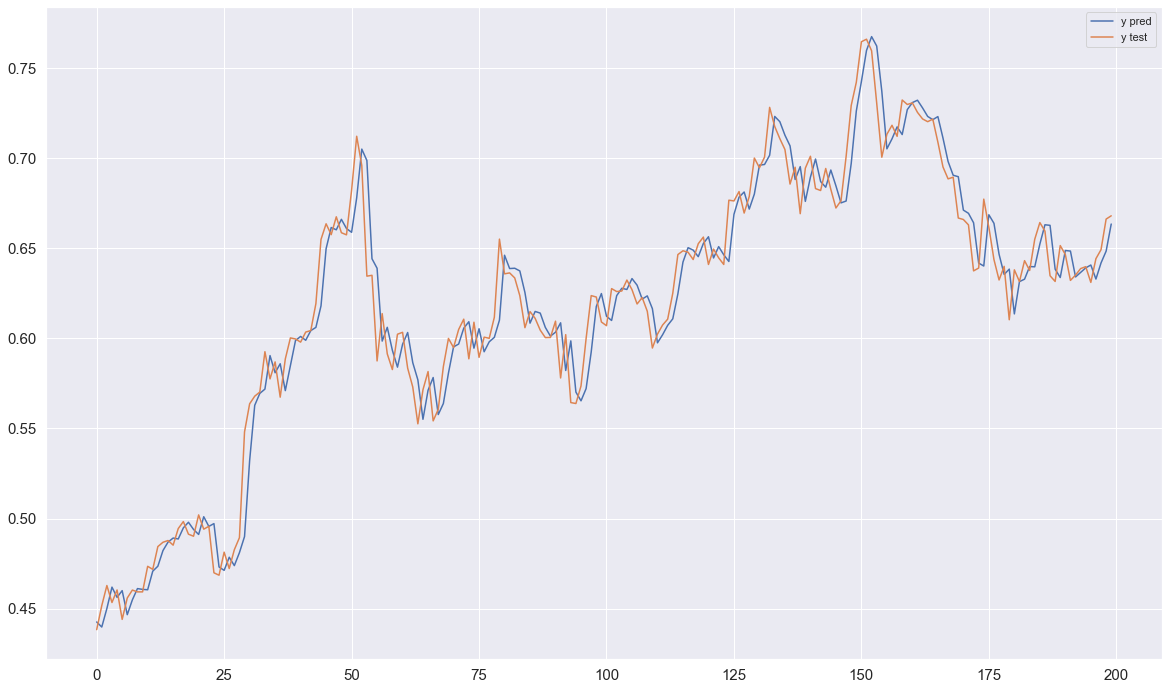

In [57]:
df = pd.DataFrame(compared, columns=['y pred', 'y test'])
df.iloc[0:200,:].plot()

# LSTM

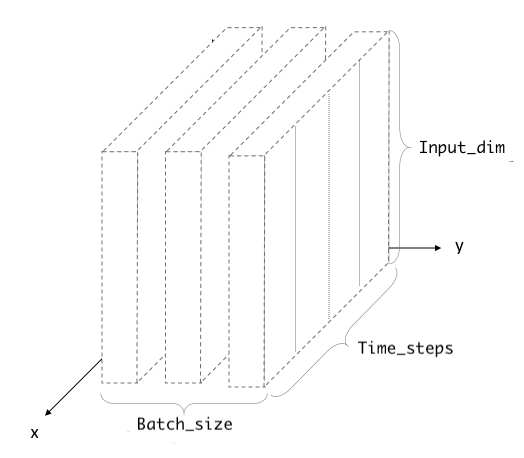

In [58]:
# Prepare Data
X = []
n_features = len(data_set.columns)
back_days = 50
print(data_set_scaled.shape[0])
for j in range(n_features):
    X.append([])
    for i in range(back_days, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-back_days:i, j])


X=np.moveaxis(X, [0], [2])


X, yi =np.array(X), np.array(data_set_scaled[back_days:,-1])
y=np.reshape(yi,(len(yi),1))



2584


In [59]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
X_train.shape

2027


(2027, 50, 11)

In [60]:
# Create model
lstm_input = Input(shape=(back_days, n_features), name='lstm_input')
inputs = LSTM(200, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
# Fit Model
model.fit(x=X_train, y=y_train, batch_size=15, epochs=10, shuffle=True, validation_split = 0.1)
#Predict 
lstm_ypred = model.predict(X_test)

Epoch 1/10
122/122 [==============================] - 6s 33ms/step - loss: 8.5219e-04 - val_loss: 4.3185e-04
Epoch 2/10
122/122 [==============================] - 4s 29ms/step - loss: 3.6009e-05 - val_loss: 4.2912e-04
Epoch 3/10
122/122 [==============================] - 4s 30ms/step - loss: 3.3962e-05 - val_loss: 3.8600e-04
Epoch 4/10
122/122 [==============================] - 4s 30ms/step - loss: 3.0295e-05 - val_loss: 2.5929e-04
Epoch 5/10
122/122 [==============================] - 4s 29ms/step - loss: 3.2740e-05 - val_loss: 2.6101e-04
Epoch 6/10
122/122 [==============================] - 4s 29ms/step - loss: 2.6675e-05 - val_loss: 2.6213e-04
Epoch 7/10
122/122 [==============================] - 4s 30ms/step - loss: 3.1942e-05 - val_loss: 2.5738e-04
Epoch 8/10
122/122 [==============================] - 4s 30ms/step - loss: 2.8485e-05 - val_loss: 2.6576e-04
Epoch 9/10
122/122 [==============================] - 4s 30ms/step - loss: 3.0829e-05 - val_loss: 2.3165e-04
Epoch 10/10
16/16 [

In [61]:
for i in range(50):
    print(lstm_ypred[i], y_test[i], f'Predictions accuracy {round(float((lstm_ypred[i] / y_test[i] - 1) * 100), 2)}% of actual value')

[0.4444966] [0.47345511] Predictions accuracy -6.12% of actual value
[0.44662935] [0.4717644] Predictions accuracy -5.33% of actual value
[0.45261484] [0.4844155] Predictions accuracy -6.56% of actual value
[0.45625004] [0.4868058] Predictions accuracy -6.28% of actual value
[0.46253532] [0.48778234] Predictions accuracy -5.18% of actual value
[0.46756643] [0.48520254] Predictions accuracy -3.63% of actual value
[0.47101897] [0.49441405] Predictions accuracy -4.73% of actual value
[0.47300443] [0.49830551] Predictions accuracy -5.08% of actual value
[0.47690284] [0.49129489] Predictions accuracy -2.93% of actual value
[0.48117352] [0.49015813] Predictions accuracy -1.83% of actual value
[0.4799419] [0.50199302] Predictions accuracy -4.39% of actual value
[0.47979593] [0.49407878] Predictions accuracy -2.89% of actual value
[0.48342037] [0.49566744] Predictions accuracy -2.47% of actual value
[0.4823204] [0.46985505] Predictions accuracy 2.65% of actual value
[0.48165655] [0.4685142] Pr

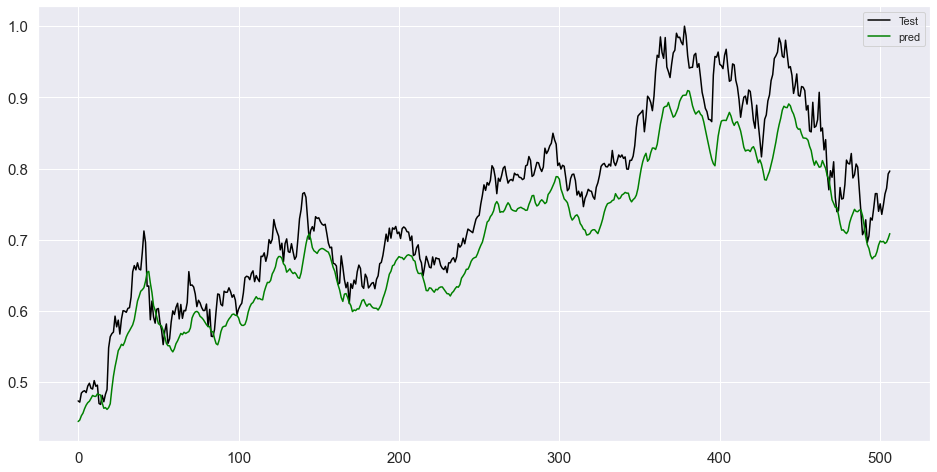

In [62]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(lstm_ypred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [63]:
lstmmodel_MSE = mean_squared_error(y_test, lstm_ypred, squared=True)
lstmmodel_MSE

0.0030049717992575668

# Metrics

#### The Mean Square Error measures the average square difference between the estimated value by the model and the real value. It is a measure of the quality of the estimator and for that reason it will be used to measure the efficiency  of the models.
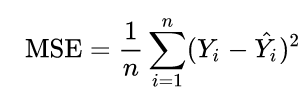

In [65]:
print(('Linear Model MSE', linmodel_MSE))
print(('LSTM Model MSE', lstmmodel_MSE))


('Linear Model MSE', 0.00026198287995764306)
('LSTM Model MSE', 0.0030049717992575668)


#### The Linear model shows the better result by avaluating the MSE compared to the LSTM model.

# Improvements

In [66]:
data2 = get_data(['AAPL'], '2012-03-11', '2022-07-10')
# Other Features
data2['RSI'] = ta.rsi(data2['Adj Close'], lenghth=15)
data2['EMAF'] = ta.ema(data2['Adj Close'], lenght=20)
data2['EMAM'] = ta.ema(data2['Adj Close'], lenght=100)
data2['EMAS'] = ta.ema(data2['Adj Close'], lenght=150)
data2['BBupper 2'] = bollinger_bands(data2['Adj Close'], 2, 2)[1]
data2['BBlower 2'] = bollinger_bands(data2['Adj Close'], 2, 2)[2]
#defining Predict as the next Adj Close Price
data2['Predict Next Day'] = data2['Adj Close'].shift(-1)
data2.dropna(inplace=True)
data2.reset_index(inplace=True)
data2.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

data2_set = data2.iloc[:, 0:11]#.values
pd.set_option('display.max_columns', None)
# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1)) #will rescale the values between 0 and 1
data2_set_scaled = sc.fit_transform(data2_set)
# Split
x_train, x_test, y_train, y_test = train_test_split_custom(data2_set_scaled, .8)

[*********************100%***********************]  1 of 1 completed


# LSTM

In [67]:
# Prepare Data
X = []
n_features = len(data_set.columns)
back_days = 50
print(data_set_scaled.shape[0])
for j in range(n_features):
    X.append([])
    for i in range(back_days, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-back_days:i, j])


X=np.moveaxis(X, [0], [2])


X, yi =np.array(X), np.array(data_set_scaled[back_days:,-1])
y=np.reshape(yi,(len(yi),1))

# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
X_train.shape


2584
2027


(2027, 50, 11)

In [79]:
# Create model
lstm_input = Input(shape=(back_days, n_features), name='lstm_input')
inputs = LSTM(250, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
# Fit Model
model.fit(x=X_train, y=y_train, batch_size=15, epochs=100, shuffle=True, validation_split = 0.1)
#Predict 
lstm_ypred2 = model.predict(X_test)

Epoch 1/100
122/122 [==============================] - 9s 56ms/step - loss: 3.4125e-04 - val_loss: 3.5102e-04
Epoch 2/100
122/122 [==============================] - 7s 54ms/step - loss: 3.0732e-05 - val_loss: 3.5530e-04
Epoch 3/100
122/122 [==============================] - 7s 56ms/step - loss: 2.5061e-05 - val_loss: 2.8839e-04
Epoch 4/100
122/122 [==============================] - 7s 54ms/step - loss: 3.2464e-05 - val_loss: 3.1607e-04
Epoch 5/100
122/122 [==============================] - 7s 55ms/step - loss: 3.3720e-05 - val_loss: 3.5397e-04
Epoch 6/100
122/122 [==============================] - 7s 54ms/step - loss: 2.5622e-05 - val_loss: 2.2734e-04
Epoch 7/100
122/122 [==============================] - 7s 55ms/step - loss: 3.4838e-05 - val_loss: 1.8842e-04
Epoch 8/100
122/122 [==============================] - 7s 55ms/step - loss: 2.7716e-05 - val_loss: 1.8472e-04
Epoch 9/100
122/122 [==============================] - 7s 56ms/step - loss: 2.4537e-05 - val_loss: 3.1446e-04
Epoch 10/1

Epoch 75/100
122/122 [==============================] - 7s 55ms/step - loss: 1.1570e-05 - val_loss: 1.5613e-04
Epoch 76/100
122/122 [==============================] - 7s 54ms/step - loss: 1.1839e-05 - val_loss: 2.0523e-04
Epoch 77/100
122/122 [==============================] - 7s 54ms/step - loss: 1.2313e-05 - val_loss: 1.4762e-04
Epoch 78/100
122/122 [==============================] - 7s 54ms/step - loss: 1.0885e-05 - val_loss: 1.6913e-04
Epoch 79/100
122/122 [==============================] - 7s 54ms/step - loss: 1.2159e-05 - val_loss: 1.5447e-04
Epoch 80/100
122/122 [==============================] - 7s 55ms/step - loss: 1.2094e-05 - val_loss: 1.4649e-04
Epoch 81/100
122/122 [==============================] - 7s 54ms/step - loss: 1.1112e-05 - val_loss: 1.4495e-04
Epoch 82/100
122/122 [==============================] - 7s 55ms/step - loss: 1.1789e-05 - val_loss: 1.8487e-04
Epoch 83/100
122/122 [==============================] - 7s 54ms/step - loss: 1.0539e-05 - val_loss: 1.4060e-04
E

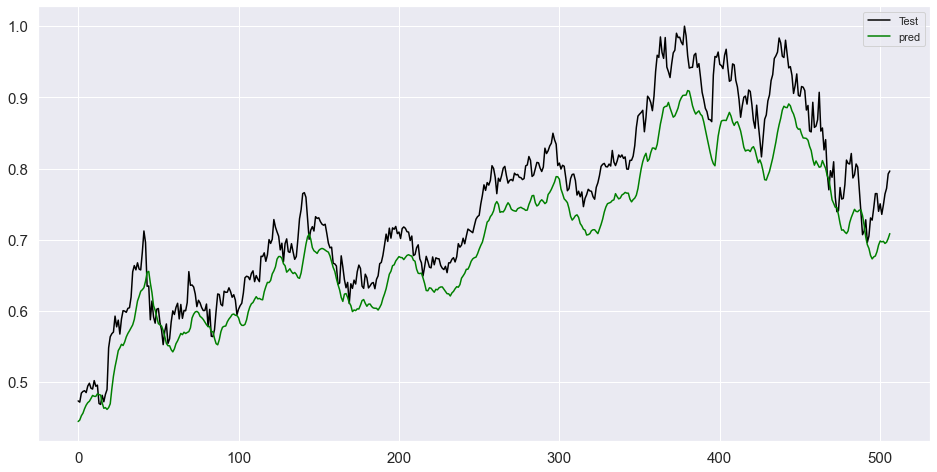

In [80]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(lstm_ypred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [70]:
lstmmodel2_MSE = mean_squared_error(y_test, lstm_ypred2, squared=True)

In [71]:
print(('LSTM Model 2 MSE', lstmmodel2_MSE))
print(('LSTM Model MSE', lstmmodel_MSE))

('LSTM Model 2 MSE', 0.001049373911667073)
('LSTM Model MSE', 0.0030049717992575668)


# Justification

#### The improvement made on the LSTM model by increasing the number of epochs  and changing the first layer shows favorable results by decreasing the MSE compared to the first LSTM model. This indicates that other tunes in the model can probably result in a more effective model. Another way to get better performance is to add other features to the model.

# Reflection

#### The entire project was very interesting to me due to my personal interest in comprehending market movements and becoming a better investor. Understanding the prices, return, volatility and correlation with other assets is fundamental to invest or trade any asset in a more efficient way. The most fascinating step to me was to create the Machine Learn Models and it was also the most difficult part as well due to not being an area that I master. This awakes me to learn more about it. 